# **Proyecto Final de Ciencia de Datos**
**Integrantes: Otto Ferrer - Gema Zambrano**

### **Estrategia de Análisis (Framework Minto)**



*   Situación: Dataset masivo (CheXpert) con datos demográficos y etiquetas clínicas.

*   Complicación: La interpretación individual no detecta sesgos poblacionales ni patrones complejos de comorbilidad.

*   Resolución: Respondemos 5 preguntas clave de negocio sobre multimorbilidad, gravedad y sesgos demográficos.

## **Contexto Clinico**


La radiografía de tórax es crítica para el diagnóstico de patologías respiratorias. Sin embargo, los hospitales enfrentan el reto de procesar miles de imágenes diarias sin una estratificación automática de riesgo. Este proyecto une datos clínicos estructurados con metadatos de imágenes para descubrir patrones ocultos.

Para alinear el análisis de datos con los objetivos clínicos, utilizamos el principio de la Pirámide de Minto para estructurar nuestra narrativa. Partimos de una situación conocida (datos radiológicos masivos), identificamos una complicación (la dificultad de estratificar riesgos complejos) y planteamos preguntas clave que nuestro análisis resolverá.



*   **Situación:** Contamos con un dataset masivo de radiografías de tórax (CheXpert) enriquecido con datos demográficos, vital para el diagnóstico hospitalario.

*   **Complicación:** Los diagnósticos aislados no revelan el perfil de riesgo integral del paciente ni posibles sesgos demográficos en la atención.

## **Preguntas de Negocio a Resolver:**

*   **Perfil de multimorbilidad:** ¿Cómo evoluciona la complejidad del cuadro clínico (carga patológica) a medida que el paciente envejece, diferenciando por género?

*   **Validacion de gravedad:** ¿Es la presencia de dispositivos médicos de soporte un indicador confiable de una alta carga patológica en el paciente?

*   **Patrones clinicos en proyeccion AP:** ¿Qué patrones clínicos están estrechamente asociados con patologías cardiacas (como cardiomegalia) y pulmonares (como atelectasis) específicamente en las radiografías AP?

*   **Factores de riesgos demograficos:** ¿Como se examina la raza y la edad como factor de riesgo para la complejidad del cuadro clínico

*   **Análisis de "No Hallazgos":** ¿Qué perfil demográfico presenta la mayor tasa de radiografías sin hallazgos patológicos ("No Finding"), indicando posibles descartes preventivos?

# Configuracion y Carga de Datos

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import jaccard_score

#1. Carga: etiquetas binarias (0/1) generadas por VisualCheXbert sobre CheXpert.
url2 = "https://github.com/ottoferrer/patient_data/raw/main/train_visualCheXbert.csv"
dataset = pd.read_csv(url2)
dataset = pd.DataFrame(dataset)
dataset.head()

# 2. Carga: datos demográficos de los pacientes en CheXpert.
url3 = 'https://github.com/ottoferrer/patient_data/raw/main/CHEXPERT%20DEMO.xlsx'
dataset_demo = pd.read_excel(url3, engine='openpyxl')
dataset_demo.head()
dataset_demo.columns

Index(['PATIENT', 'GENDER', 'AGE_AT_CXR', 'PRIMARY_RACE', 'ETHNICITY'], dtype='object')

# Preprocesamiento y Unificación

In [34]:
# dataset contiene informacion en la columna 'Path' por lo que se  separa por cada '/' y obtener  en una nueva columna'
dataset[['version','split','Patient_id','Study','Image']] = dataset['Path'].str.split('/', expand=True)
print(dataset.shape)
dataset.head()

(223414, 24)


,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,...,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,version,split,Patient_id,Study,Image
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,CheXpert-v1.0,train,patient00001,study1,view1_frontal.jpg
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study2,view1_frontal.jpg
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study1,view1_frontal.jpg
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study1,view2_lateral.jpg
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,CheXpert-v1.0,train,patient00003,study1,view1_frontal.jpg


In [35]:
#Se estan renombrando las columnas del dataset demografico para que coincidan con el dataset principal
dataset_demo = dataset_demo.rename(columns={'PRIMARY_RACE': 'Race'})
dataset_demo = dataset_demo.rename(columns={'PATIENT': 'Patient_id'})
dataset_demo = dataset_demo.rename(columns={'GENDER': 'Sex'})
dataset_demo = dataset_demo.rename(columns={'AGE_AT_CXR': 'Age'})
dataset_demo = dataset_demo.rename(columns={'ETHNICITY': 'Ethnicity'})
dataset_demo.head()

,Patient_id,Sex,Age,Race,Ethnicity
0,patient24428,Male,61,White,Non-Hispanic/Non-Latino
1,patient48289,Female,39,Other,Hispanic/Latino
2,patient33856,Female,81,White,Non-Hispanic/Non-Latino
3,patient41673,Female,42,Unknown,Unknown
4,patient48493,Male,71,White,Non-Hispanic/Non-Latino


In [38]:
#creacion del nuevo dataset uniendo ambos datasets por la columna 'Patient_id'
dataset_demo_l = dataset_demo.drop(['Sex', 'Age'], axis=1)
final_dataset = pd.merge(dataset, dataset_demo_l, on='Patient_id', how='left')
print(final_dataset.shape)
final_dataset.head()

(223414, 26)


,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,...,Fracture,Support Devices,No Finding,version,split,Patient_id,Study,Image,Race,Ethnicity
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,CheXpert-v1.0,train,patient00001,study1,view1_frontal.jpg,Other,Non-Hispanic/Non-Latino
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study2,view1_frontal.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study1,view1_frontal.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study1,view2_lateral.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,CheXpert-v1.0,train,patient00003,study1,view1_frontal.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino


# Limpieza de Datos
Se identifican y gestionan los valores nulos. Específicamente, se eliminan registros con información faltante en la proyección (AP/PA), raza o etnia, dado que son críticos para el análisis radiológico.

In [41]:
#Revisión de valores nulos en el nuevo dataset
final_dataset.isnull().sum()
#Porcentaje de ruido en cada columna
print(final_dataset.isnull().mean()*100)

#seleccionar solo las filas sin valores nulos
final_dataset_clean = final_dataset.dropna().copy()
final_dataset_clean.isnull().sum()
print(final_dataset_clean.shape)
final_dataset_clean.head()

Path                           0.000000
Sex                            0.000000
Age                            0.000000
Frontal/Lateral                0.000000
AP/PA                         14.496406
Enlarged Cardiomediastinum     0.000000
Cardiomegaly                   0.000000
Lung Opacity                   0.000000
Lung Lesion                    0.000000
Edema                          0.000000
Consolidation                  0.000000
Pneumonia                      0.000000
Atelectasis                    0.000000
Pneumothorax                   0.000000
Pleural Effusion               0.000000
Pleural Other                  0.000000
Fracture                       0.000000
Support Devices                0.000000
No Finding                     0.000000
version                        0.000000
split                          0.000000
Patient_id                     0.000000
Study                          0.000000
Image                          0.000000
Race                           1.077820


,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,...,Fracture,Support Devices,No Finding,version,split,Patient_id,Study,Image,Race,Ethnicity
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,CheXpert-v1.0,train,patient00001,study1,view1_frontal.jpg,Other,Non-Hispanic/Non-Latino
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study2,view1_frontal.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study1,view1_frontal.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,CheXpert-v1.0,train,patient00003,study1,view1_frontal.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino
5,CheXpert-v1.0/train/patient00004/study1/view1_...,Female,20,Frontal,PA,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,CheXpert-v1.0,train,patient00004,study1,view1_frontal.jpg,Black or African American,Non-Hispanic/Non-Latino


# Estandarización de Variables Categóricas (Raza y Etnia)
Se normalizan las categorías de las variables 'Race' y 'Ethnicity' para reducir la variabilidad y agrupar términos similares (por ejemplo, agrupar distintas variaciones de 'White' o 'Hispanic').

In [42]:
# Revisión de la variable 'Race'
print(final_dataset_clean['Race'].value_counts())

# Estandarizacion de categorias de la variable 'Race'

final_dataset_clean["race_standardized"] = np.nan

# Se normalizan los datos en minúsculas y se eliminan espacios en blanco
final_dataset_clean["race_raw_clean"] = (final_dataset_clean["Race"].str.lower().str.strip())

# White
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("white|caucasian", na=False),
       "race_standardized"] = "White"

# Black or African American
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("black|african", na=False),
       "race_standardized"] = "Black or African American"

# Asian
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("asian", na=False),
       "race_standardized"] = "Asian"

# American Indian or Alaska Native
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("american indian|native american|alaska", na=False),
       "race_standardized"] = "American Indian or Alaska Native"

# Native Hawaiian or Other Pacific Islander
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("hawaiian|pacific islander", na=False),
       "race_standardized"] = "Native Hawaiian or Other Pacific Islander"

# Other
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("^other| other,", regex=True, na=False),
       "race_standardized"] = "Other"

# Unknown / Not Reported
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("unknown|refused", na=False),
       "race_standardized"] = "Unknown / Not Reported"

#revision de los resultados
print(final_dataset_clean['race_standardized'].value_counts())

Race
White                                        86439
Other                                        23175
White, non-Hispanic                          20179
Asian                                        17076
Unknown                                      13520
Black or African American                     8177
Race and Ethnicity Unknown                    7907
Other, Hispanic                               3237
Asian, non-Hispanic                           2518
Native Hawaiian or Other Pacific Islander     2186
Black, non-Hispanic                           1825
White, Hispanic                                861
Other, non-Hispanic                            521
American Indian or Alaska Native               383
Patient Refused                                342
Pacific Islander, non-Hispanic                 290
Native American, non-Hispanic                   51
Black, Hispanic                                 51
Asian, Hispanic                                 34
Native American, Hispanic 

In [44]:
# Revisión de la variable 'Ethnicity'
print(final_dataset_clean['Ethnicity'].value_counts())

# Estandarizacion de categorias de la variable 'Ethnicity'

final_dataset_clean["ethnicity_standardized"] = np.nan

# Limpiar texto
final_dataset_clean["ethnicity_clean"] = (
    final_dataset_clean["Ethnicity"]
    .str.lower()
    .str.strip()
)
# Hispanic / Latino
final_dataset_clean.loc[
    final_dataset_clean["ethnicity_clean"].str.contains("hispanic|latino", na=False),
    "ethnicity_standardized"
] = "Hispanic / Latino"


# Non-Hispanic
final_dataset_clean.loc[
    final_dataset_clean["ethnicity_clean"].str.contains("non-hispanic|not hispanic", na=False),
    "ethnicity_standardized"
] = "Non-Hispanic"

# Unknown / Not Reported
final_dataset_clean.loc[
    final_dataset_clean["ethnicity_clean"].str.contains("unknown|patient refused", na=False),
    "ethnicity_standardized"
] = "Unknown / Not Reported"

# Forzar Unknown si quedó algo sin clasificar
final_dataset_clean["ethnicity_standardized"] = (
    final_dataset_clean["ethnicity_standardized"]
    .fillna("Unknown / Not Reported")
)

#revision de los resultados
print(final_dataset_clean["ethnicity_standardized"].value_counts())

Ethnicity
Non-Hispanic/Non-Latino    138132
Unknown                     28249
Hispanic/Latino             22052
Patient Refused               381
Not Hispanic                   13
Hispanic                        1
Name: count, dtype: int64
ethnicity_standardized
Non-Hispanic              138145
Unknown / Not Reported     28630
Hispanic / Latino          22053
Name: count, dtype: int64


# Revisión y Consistencia de Variables
Se verifica la consistencia de otras variables importantes como 'Sex', 'AP/PA' (eliminando proyecciones laterales erróneas), 'Frontal/Lateral' y se revisan las columnas resultantes del proceso.

In [45]:
final_dataset_clean.columns
print(final_dataset_clean["Sex"].value_counts())

Sex
Male      110809
Female     78019
Name: count, dtype: int64


In [46]:
print(final_dataset_clean['AP/PA'].value_counts())
#se eliminan las observacion con LL y RL en la columna 'AP/PA'
final_dataset_clean = final_dataset_clean[~final_dataset_clean['AP/PA'].isin(['LL', 'RL'])]
print(final_dataset_clean['AP/PA'].value_counts())

AP/PA
AP    159609
PA     29202
LL        16
RL         1
Name: count, dtype: int64
AP/PA
AP    159609
PA     29202
Name: count, dtype: int64


In [47]:
print(final_dataset_clean['Frontal/Lateral'].value_counts())

Frontal/Lateral
Frontal    188811
Name: count, dtype: int64


In [58]:
print(final_dataset_clean['version'].value_counts())
print(final_dataset_clean['split'].value_counts())
print(final_dataset_clean['Patient_id'].nunique())
print(final_dataset_clean['Study'].nunique())
print(final_dataset_clean['Image'].value_counts())

version
CheXpert-v1.0    188811
Name: count, dtype: int64
split
train    188811
Name: count, dtype: int64
63688
91
Image
view1_frontal.jpg    185456
view2_frontal.jpg      3315
view3_frontal.jpg        40
Name: count, dtype: int64


In [59]:
final_dataset_clean.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'No Finding', 'version', 'split', 'Patient_id',
       'Study', 'Image', 'Race', 'Ethnicity', 'race_standardized',
       'race_raw_clean', 'ethnicity_standardized', 'ethnicity_clean',
       'age_group'],
      dtype='object')

# Análisis Exploratorio (Edad)
Comienza el análisis descriptivo enfocándose en la variable 'Edad'. Se calculan estadísticas básicas y se genera un histograma para visualizar la distribución de edades de los pacientes.

In [60]:
# estadisticas descriptivas de la edad
print(final_dataset_clean['Age'].describe())

count    188811.000000
mean         60.870283
std          17.911400
min          18.000000
25%          50.000000
50%          62.000000
75%          74.000000
max         110.000000
Name: Age, dtype: float64


Text(0.5, 1.0, 'Distribución de la Edad de los Pacientes')

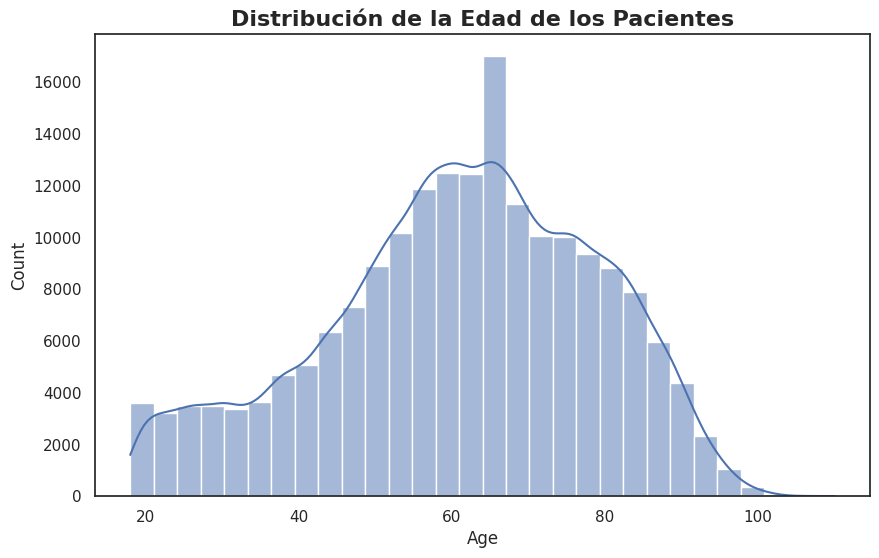

In [61]:
#grafica de la distribucion de la edad
plt.figure(figsize=(10,6))
sns.histplot(final_dataset_clean['Age'], bins=30, kde=True)
plt.title('Distribución de la Edad de los Pacientes')

# Análisis Bivariado de la Edad
Se explora la distribución de la edad condicionada por el sexo del paciente mediante un gráfico de densidad (KDE), lo que permite observar diferencias demográficas en la estructura poblacional de la muestra hospitalaria.

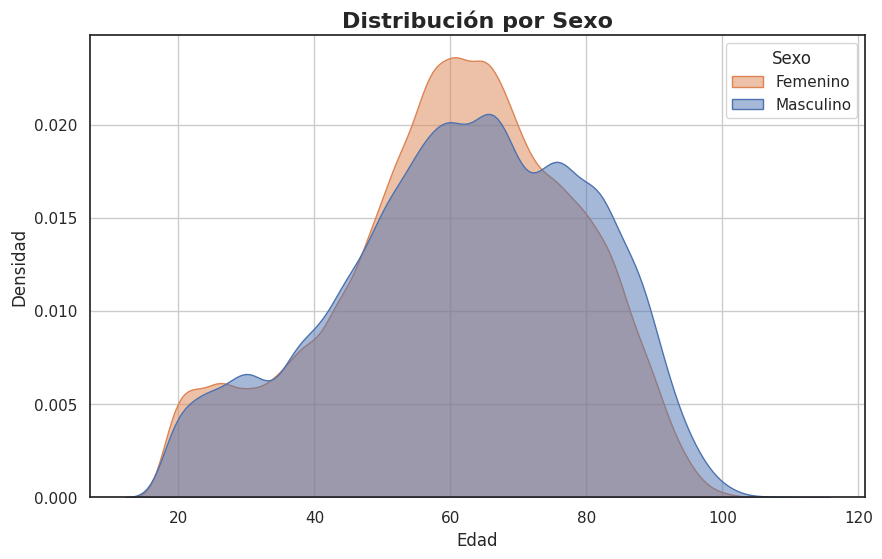

In [62]:
#grafica de edad por sexo
plt.figure(figsize=(10,6))

sns.kdeplot(data=final_dataset_clean, x='Age', hue='Sex', fill=True, common_norm=False, alpha=0.5)

plt.title('Distribución por Sexo')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.legend(title='Sexo', labels=['Femenino', 'Masculino'])
plt.grid()

# Mostramos la gráfica
plt.show()

# Segmentación por Grupos Etarios
Para facilitar el análisis clínico, se discretiza la variable continua 'Edad' en grupos etarios definidos (jóvenes, adultos, adultos mayores, etc.) y se calcula la frecuencia absoluta y relativa de pacientes en cada segmento.

In [63]:
# Tabla de frecuencia de grupos de edad
bins = [18, 29, 44, 59, 74, np.inf]
labels = ['18–29', '30–44', '45–59', '60–74', '75+']


final_dataset_clean['age_group'] = pd.cut(final_dataset_clean['Age'], bins=bins, labels=labels, right=True)
freq_table = final_dataset_clean['age_group'].value_counts().sort_index()
freq_rel = freq_table / freq_table.sum()

# Tabla final
tabla_frecuencia = pd.DataFrame({
    'Frecuencia absoluta': freq_table,
    'Frecuencia relativa': freq_rel.round(3)
})

tabla_frecuencia

,Frecuencia absoluta,Frecuencia relativa
age_group,,
18–29,11899,0.063
30–44,22303,0.118
45–59,48827,0.259
60–74,58138,0.309
75+,47072,0.250


In [64]:
final_dataset_clean.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'No Finding', 'version', 'split', 'Patient_id',
       'Study', 'Image', 'Race', 'Ethnicity', 'race_standardized',
       'race_raw_clean', 'ethnicity_standardized', 'ethnicity_clean',
       'age_group'],
      dtype='object')

# Distribución Demográfica por Etnia y Raza
Se profundiza en el análisis demográfico visualizando la distribución de edades separada por los grupos étnicos y raciales estandarizados previamente. Se emplea una visualización facetada para comparar las distribuciones de edad entre las distintas razas.

3


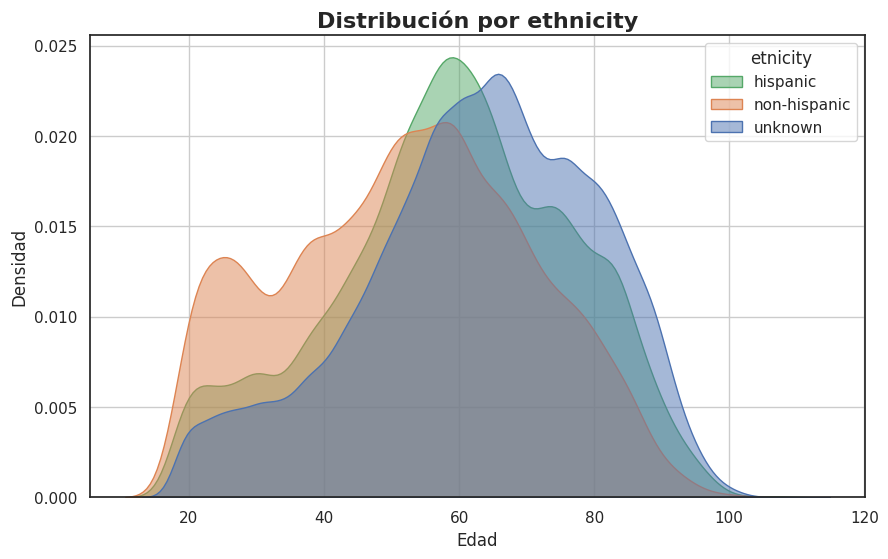

In [65]:
#grafica de edad por etnia
plt.figure(figsize=(10,6))

print(final_dataset_clean['ethnicity_standardized'].nunique())
sns.kdeplot(data=final_dataset_clean, x='Age', hue='ethnicity_standardized', fill=True, common_norm=False, alpha=0.5)

plt.title('Distribución por ethnicity')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.legend(title='etnicity', labels=['hispanic', 'non-hispanic', 'unknown'])
plt.grid()

# Mostramos la gráfica
plt.show()

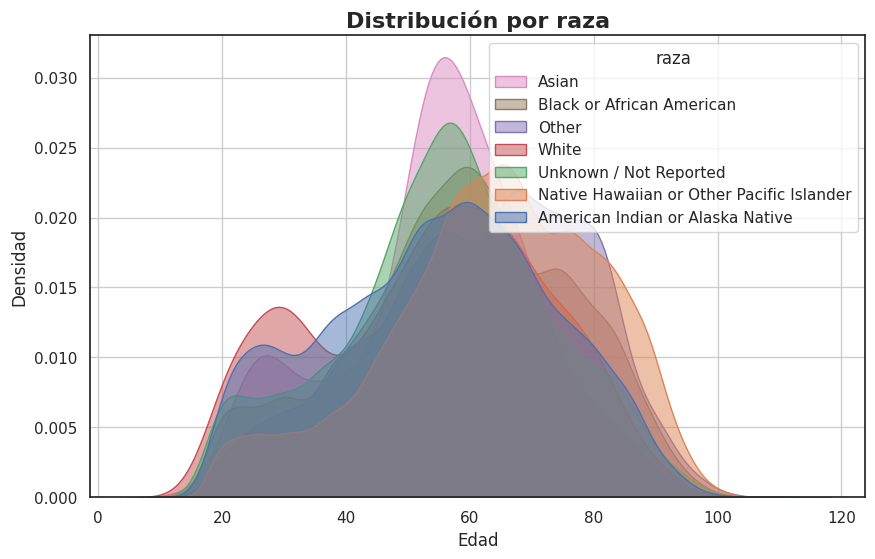

In [66]:
#grafica de edad por raza
plt.figure(figsize=(10,6))

sns.kdeplot(data=final_dataset_clean, x='Age', hue='race_standardized', fill=True, common_norm=False, alpha=0.5)

plt.title('Distribución por raza')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.legend(title='raza', labels=['Asian', 'Black or African American', 'Other', 'White','Unknown / Not Reported' , 'Native Hawaiian or Other Pacific Islander', 'American Indian or Alaska Native'])
plt.grid()

# Mostramos la gráfica
plt.show()

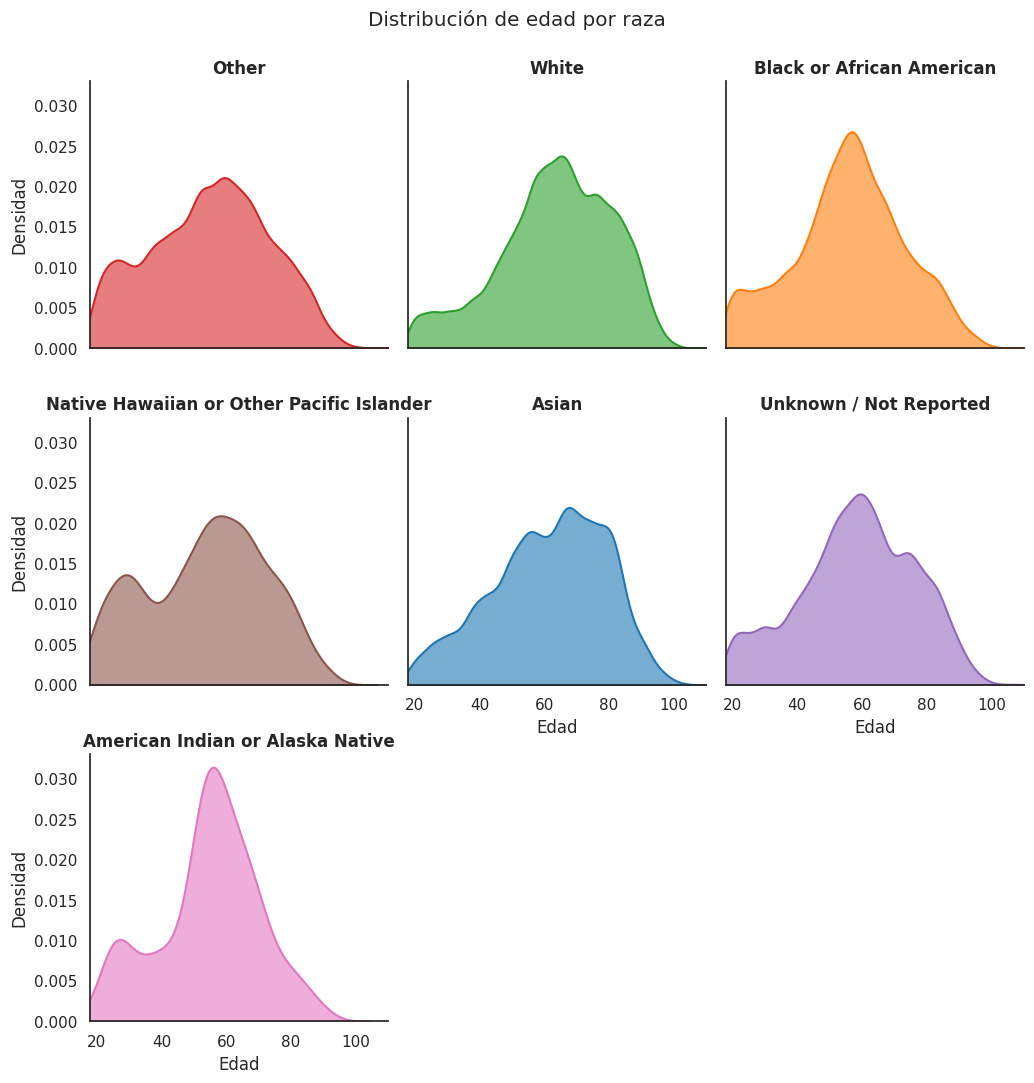

In [67]:
# Paleta fija por raza
race_palette = {
    'Asian': '#1f77b4',
    'Black or African American': '#ff7f0e',
    'White': '#2ca02c',
    'Other': '#d62728',
    'Unknown / Not Reported': '#9467bd',
    'Native Hawaiian or Other Pacific Islander': '#8c564b',
    'American Indian or Alaska Native': '#e377c2'
}

# Crear FacetGrid
g = sns.FacetGrid(
    final_dataset_clean,
    col="race_standardized",
    col_wrap=3,
    height=3.5,
    sharex=True,
    sharey=True
)

# Función para KDE con color por panel
def kde_by_race(data, color=None, **kwargs):
    race = data['race_standardized'].iloc[0]
    sns.kdeplot(
        data=data,
        x="Age",
        fill=True,
        alpha=0.6,
        linewidth=1.5,
        color=race_palette.get(race, 'gray')
    )

# Aplicar la función
g.map_dataframe(kde_by_race)

# Forzar misma escala X
xmin = final_dataset_clean["Age"].min()
xmax = final_dataset_clean["Age"].max()
g.set(xlim=(xmin, xmax))

# Etiquetas y título
g.set_axis_labels("Edad", "Densidad")
g.set_titles("{col_name}")
g.fig.suptitle("Distribución de edad por raza", y=1.03)

plt.show()

# Definición y Análisis de Prevalencia de Hallazgos
Se define la lista oficial de hallazgos radiológicos (etiquetas) y se calcula la prevalencia general de cada patología en el conjunto de datos completo, visualizando los resultados ordenados en un gráfico de barras horizontales.

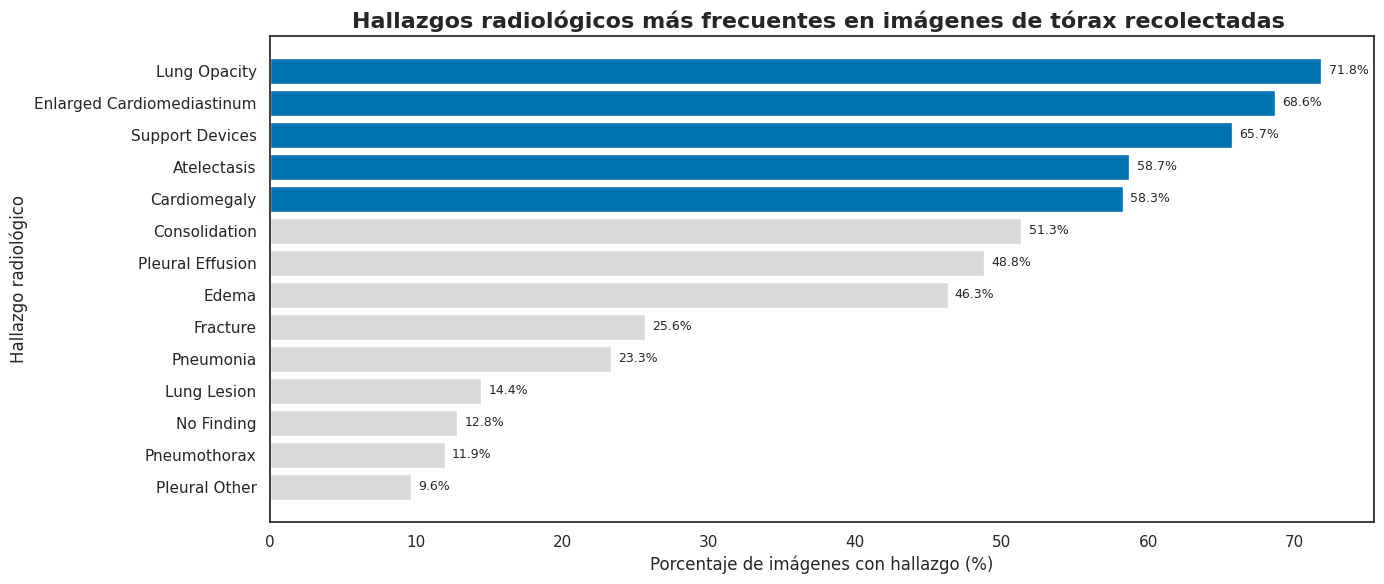

In [68]:
labels = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices'
]

df_0=final_dataset_clean

porcentajes = []
for label in labels:
    porcentaje = (df_0[label] == 1).mean() * 100
    porcentajes.append(porcentaje)

df_porcentajes = pd.DataFrame({
    'label': labels,
    'porcentaje': porcentajes
}).sort_values('porcentaje', ascending=True)  # ascendente para horizontal

top5_labels = df_porcentajes['label'].tail(5).tolist()
colors = ['#0072B2' if label in top5_labels else '#D9D9D9'
          for label in df_porcentajes['label']]

plt.figure(figsize=(14, 6))
bars = plt.barh(
    df_porcentajes['label'],
    df_porcentajes['porcentaje'],
    color=colors
)

plt.xlabel('Porcentaje de imágenes con hallazgo (%)')
plt.ylabel('Hallazgo radiológico')
plt.title('Hallazgos radiológicos más frecuentes en imágenes de tórax recolectadas ')

# Etiquetas de porcentaje al final de cada barra
for bar in bars:
    width = bar.get_width()
    plt.annotate(
        f'{width:.1f}%',
        (width + 0.5, bar.get_y() + bar.get_height() / 2),
        va='center',
        ha='left',
        fontsize=9
    )

plt.tight_layout()
plt.show()

# Análisis Específico: Proyección Posteroanterior (PA)
Se analiza específicamente el subconjunto de radiografías con proyección PA (estándar). Se calculan frecuencias de hallazgos y se genera una matriz de co-ocurrencia (Índice de Jaccard) para identificar patologías que suelen presentarse simultáneamente, resaltando grupos clínicos (cardíaco y pulmonar).

In [69]:
# nuemero de pacientes unicos por radiografia AP/PA
print(final_dataset_clean.groupby('AP/PA')['Patient_id'].nunique())

# Agrupación por 'AP/PA' y 'Sex'
print(final_dataset_clean.groupby(['AP/PA', 'Sex'])['Patient_id'].nunique())

AP/PA
AP    52635
PA    20360
Name: Patient_id, dtype: int64
AP/PA  Sex   
AP     Female    24129
       Male      28506
PA     Female     7728
       Male      12632
Name: Patient_id, dtype: int64


### a. RX PA(Posteroanterior)- rayos X entra por la espalda y sale por el pecho

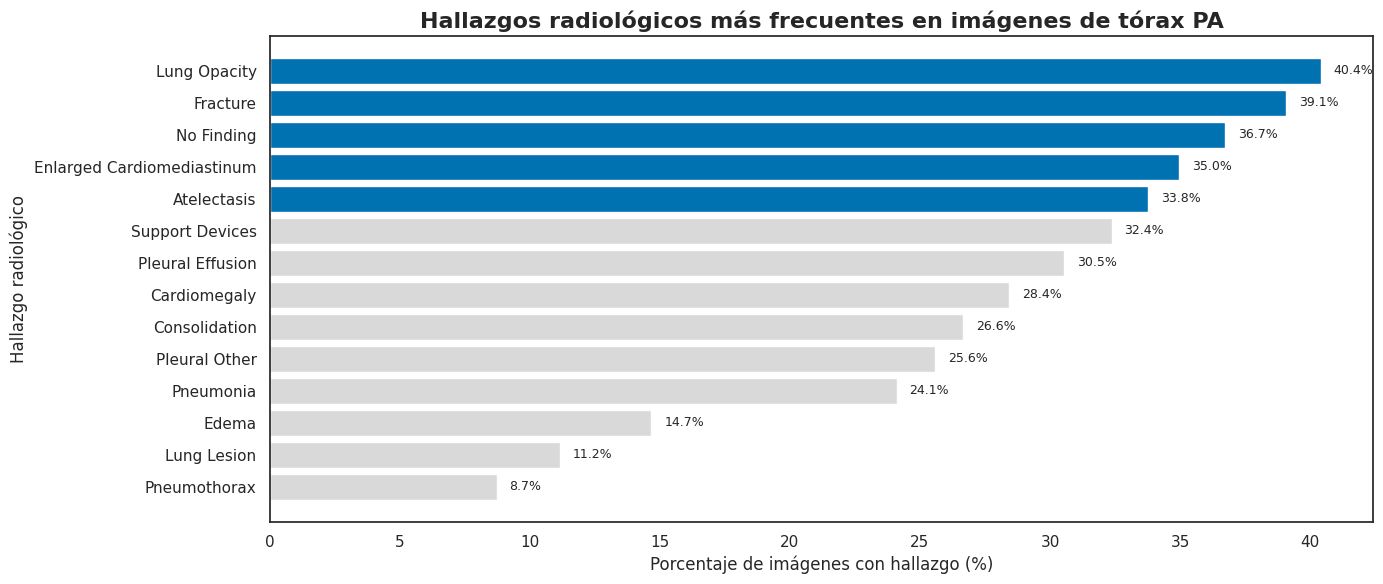

In [70]:
#Porcentaje de cada hallazgo radiológico en imágenes PA

df_1=final_dataset_clean[final_dataset_clean['AP/PA']=='PA']

porcentajes = []
for label in labels:
    porcentaje = (df_1[label] == 1).mean() * 100
    porcentajes.append(porcentaje)

df_porcentajes = pd.DataFrame({
    'label': labels,
    'porcentaje': porcentajes
}).sort_values('porcentaje', ascending=True)  # ascendente para horizontal

top5_labels = df_porcentajes['label'].tail(5).tolist()
colors = ['#0072B2' if label in top5_labels else '#D9D9D9'
          for label in df_porcentajes['label']]

plt.figure(figsize=(14, 6))
bars = plt.barh(
    df_porcentajes['label'],
    df_porcentajes['porcentaje'],
    color=colors
)

plt.xlabel('Porcentaje de imágenes con hallazgo (%)')
plt.ylabel('Hallazgo radiológico')
plt.title('Hallazgos radiológicos más frecuentes en imágenes de tórax PA')

# Etiquetas de porcentaje al final de cada barra
for bar in bars:
    width = bar.get_width()
    plt.annotate(
        f'{width:.1f}%',
        (width + 0.5, bar.get_y() + bar.get_height() / 2),
        va='center',
        ha='left',
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [71]:
#Tabla resumen de conteos por cada etiqueta de los hallazgos radiológicos PA
summary_data = []
for label in labels:
    count_0 = (df_1[label] == 0).sum()
    count_1 = (df_1[label] == 1).sum()
    total = count_0 + count_1
    summary_data.append({
        'Label': label,
        'Count_0': count_0,
        'Count_1': count_1,
        'Total': total
    })
summary_df = pd.DataFrame(summary_data)
print(summary_df)

                         Label  Count_0  Count_1  Total
0                   No Finding    18479    10723  29202
1   Enlarged Cardiomediastinum    18993    10209  29202
2                 Cardiomegaly    20905     8297  29202
3                 Lung Opacity    17404    11798  29202
4                  Lung Lesion    25942     3260  29202
5                        Edema    24916     4286  29202
6                Consolidation    21422     7780  29202
7                    Pneumonia    22164     7038  29202
8                  Atelectasis    19345     9857  29202
9                 Pneumothorax    26655     2547  29202
10            Pleural Effusion    20283     8919  29202
11               Pleural Other    21732     7470  29202
12                    Fracture    17795    11407  29202
13             Support Devices    19751     9451  29202


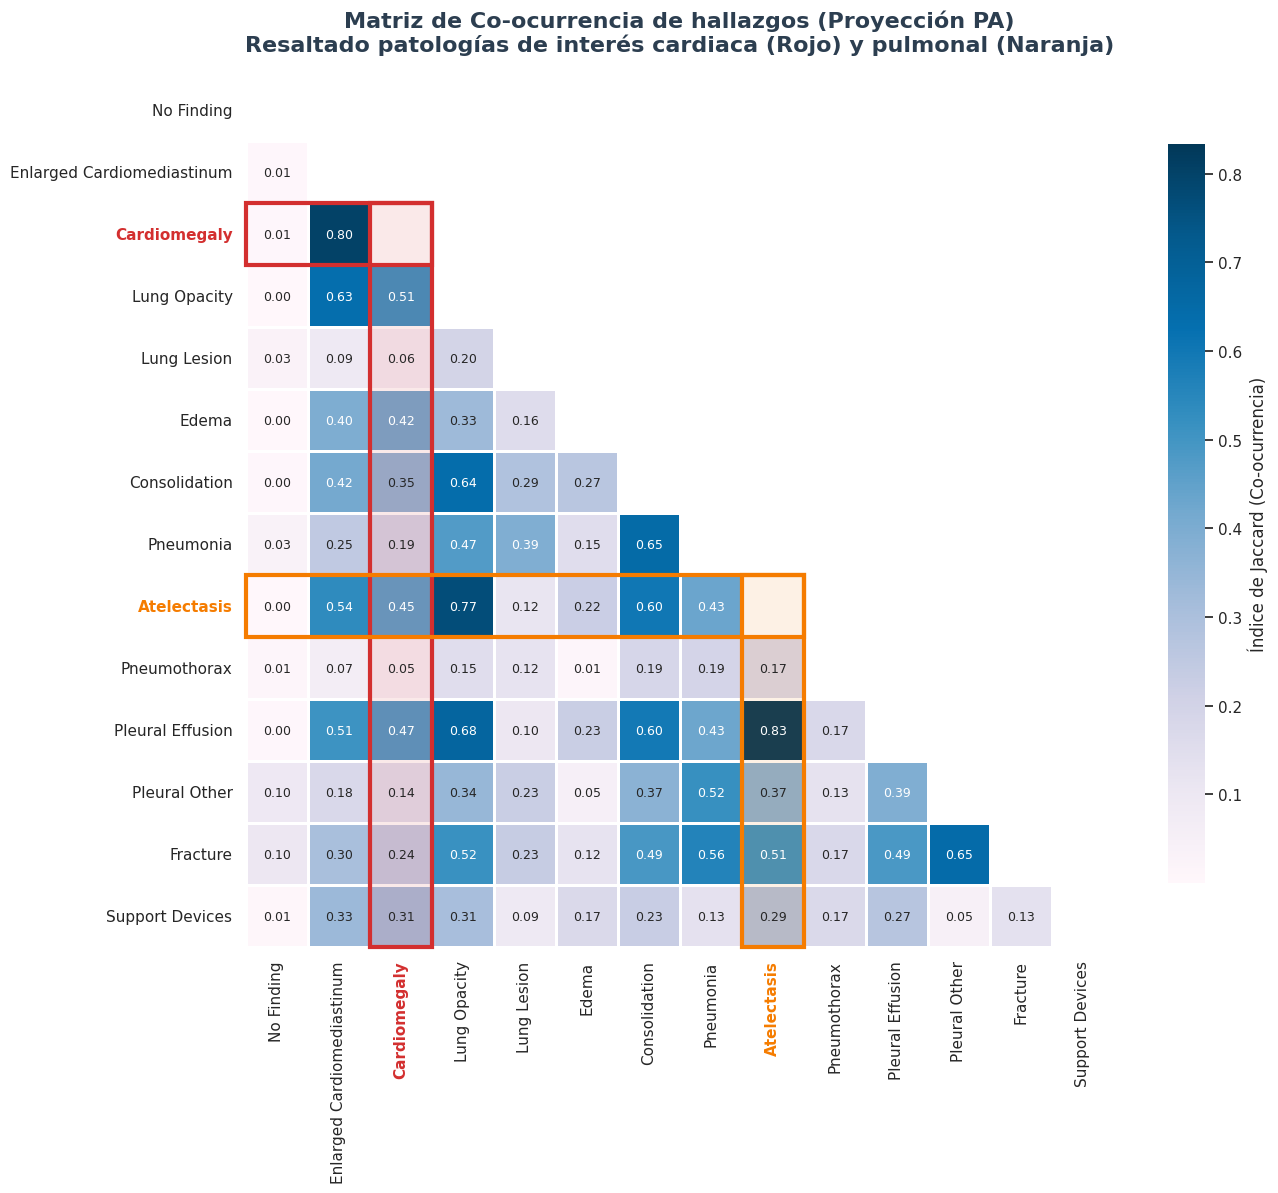

In [72]:
# Analisis de coocurrencias PA
jaccard_matrix = pd.DataFrame(index=labels, columns=labels)

for row_label in labels:
    for col_label in labels:
        if row_label == col_label:
            jaccard_matrix.loc[row_label, col_label] = 1.0
        else:
            # Calculamos Jaccard solo entre estas dos columnas
            y_true = df_1[row_label]
            y_pred = df_1[col_label]

            score = jaccard_score(y_true, y_pred, average='binary')
            jaccard_matrix.loc[row_label, col_label] = score

# Convertimos a float para graficar
jaccard_matrix = jaccard_matrix.astype(float)

import matplotlib.patches as patches
MEDICAL_COLORS = {
    'heatmap_bg': 'PuBu',
    'cardio': '#D32F2F',
    'lung':   '#F57C00',
    'text':   '#2C3E50'
}


mask = np.triu(np.ones_like(jaccard_matrix, dtype=bool))

plt.figure(figsize=(14, 12))


ax = sns.heatmap(jaccard_matrix,
                 mask=mask,
                 annot=True,
                 fmt=".2f",
                 cmap=MEDICAL_COLORS['heatmap_bg'],
                 cbar_kws={"shrink": .8, "label": "Índice de Jaccard (Co-ocurrencia)"},
                 linewidths=1,          # Líneas blancas separadoras (estilo tabla clínica)
                 linecolor='white',
                 square=True,           # Celdas cuadradas perfectas
                 annot_kws={"size": 9}  # Tamaño de letra discreto
                 )



highlights = [
    {'label': 'Cardiomegaly', 'color': MEDICAL_COLORS['cardio'], 'group': 'Patología Cardíaca'},
    {'label': 'Atelectasis',  'color': MEDICAL_COLORS['lung'],   'group': 'Patología Pulmonar'}
]

for item in highlights:
    target = item['label']
    color = item['color']

    if target in labels:
        idx = labels.index(target)

        # A. EL RECTÁNGULO VERTICAL

        rect_col = patches.Rectangle(
            (idx, idx),
            1, len(labels) - idx,
            linewidth=3,
            edgecolor=color,
            facecolor=color,
            alpha=0.1,             # Transparencia leve de fondo
            clip_on=False
        )
        # Borde fuerte encima del relleno
        rect_col_border = patches.Rectangle(
            (idx, idx),
            1, len(labels) - idx,
            linewidth=3,
            edgecolor=color,
            facecolor='none',
            clip_on=False
        )
        ax.add_patch(rect_col)
        ax.add_patch(rect_col_border)

        # B. EL RECTÁNGULO HORIZONTAL (Fila)
        rect_row = patches.Rectangle(
            (0, idx),
            idx + 1, 1,
            linewidth=3,
            edgecolor=color,
            facecolor='none',
            clip_on=False
        )
        ax.add_patch(rect_row)

        # C. ETIQUETAS COLOREADAS
        # Eje X
        ax.get_xticklabels()[idx].set_color(color)
        ax.get_xticklabels()[idx].set_fontweight('bold')
        ax.get_xticklabels()[idx].set_fontsize(11)

        # Eje Y
        ax.get_yticklabels()[idx].set_color(color)
        ax.get_yticklabels()[idx].set_fontweight('bold')
        ax.get_yticklabels()[idx].set_fontsize(11)

plt.title("Matriz de Co-ocurrencia de hallazgos (Proyección PA)\nResaltado patologías de interés cardiaca (Rojo) y pulmonal (Naranja)",
          fontsize=16, color=MEDICAL_COLORS['text'], pad=20)

plt.show()

El dataset contiene hallazgos radiológicos que no son mutuamente excluyentes y que presentan una jerarquía clínica, por lo que varios de ellos pueden encontrarse relacionados o correlacionados entre sí. En este contexto, se utiliza el índice de Jaccard para medir la similitud entre los distintos hallazgos.

El heatmap de similitud permite visualizar la coexistencia y relación entre los hallazgos radiológicos, evidenciando la presencia de patrones clínicos redundantes o estrechamente asociados, como es el caso de cardiomediastino agrandado y cardiomegalia, ambos relacionados con el agrandamiento del corazón.

# Análisis Específico: Proyección Anteroposterior (AP)
Se replica el análisis descriptivo y de co-ocurrencia para la proyección AP. Esto permite contrastar la prevalencia de hallazgos en este grupo (generalmente pacientes más graves o encamados) respecto a la proyección estándar PA.

### b. RX Anteposterior- rayos X entra por la espalda y sale por el pecho

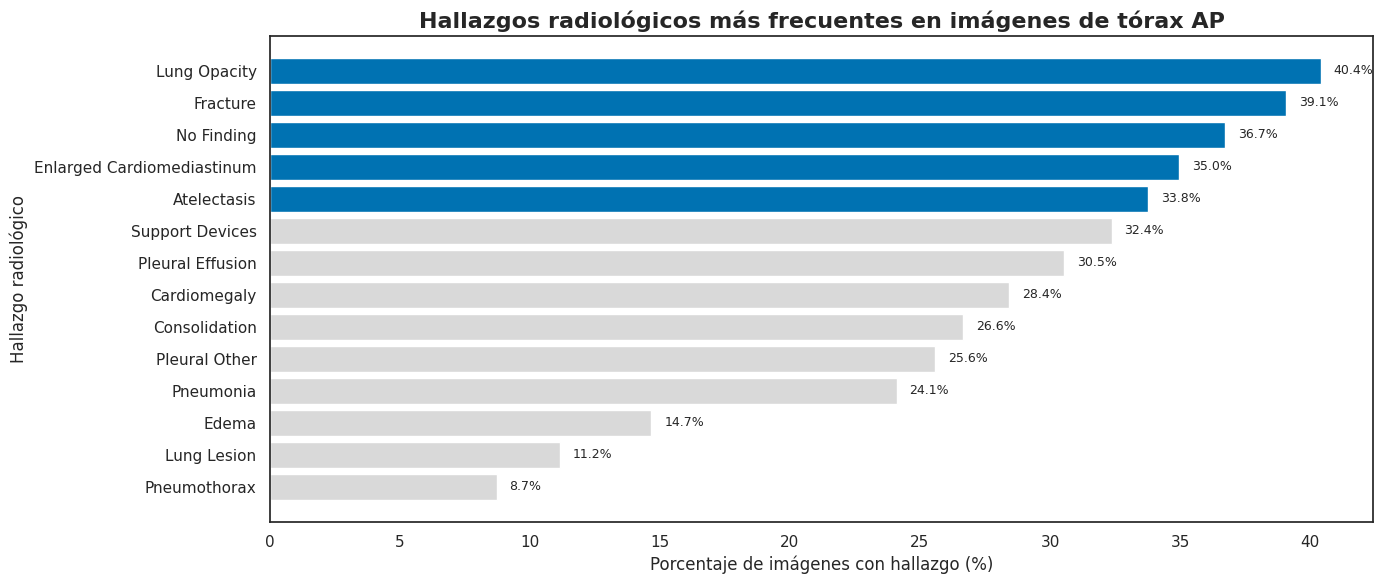

In [73]:
df_2=final_dataset_clean[final_dataset_clean['AP/PA']=='AP']

porcentajes = []
for label in labels:
    porcentaje = (df_1[label] == 1).mean() * 100
    porcentajes.append(porcentaje)

df_porcentajes = pd.DataFrame({
    'label': labels,
    'porcentaje': porcentajes
}).sort_values('porcentaje', ascending=True)  # ascendente para horizontal

top5_labels = df_porcentajes['label'].tail(5).tolist()
colors = ['#0072B2' if label in top5_labels else '#D9D9D9'
          for label in df_porcentajes['label']]

plt.figure(figsize=(14, 6))
bars = plt.barh(
    df_porcentajes['label'],
    df_porcentajes['porcentaje'],
    color=colors
)

plt.xlabel('Porcentaje de imágenes con hallazgo (%)')
plt.ylabel('Hallazgo radiológico')
plt.title('Hallazgos radiológicos más frecuentes en imágenes de tórax AP')

# Etiquetas de porcentaje al final de cada barra
for bar in bars:
    width = bar.get_width()
    plt.annotate(
        f'{width:.1f}%',
        (width + 0.5, bar.get_y() + bar.get_height() / 2),
        va='center',
        ha='left',
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [74]:
#Tabla resumen de conteos por cada etiqueta de los hallazgos radiológicos PA
summary_data = []
for label in labels:
    count_0 = (df_2[label] == 0).sum()
    count_1 = (df_2[label] == 1).sum()
    total = count_0 + count_1
    summary_data.append({
        'Label': label,
        'Count_0': count_0,
        'Count_1': count_1,
        'Total': total
    })
summary_df = pd.DataFrame(summary_data)
print(summary_df)

                         Label  Count_0  Count_1   Total
0                   No Finding   146177    13432  159609
1   Enlarged Cardiomediastinum    40212   119397  159609
2                 Cardiomegaly    57892   101717  159609
3                 Lung Opacity    35775   123834  159609
4                  Lung Lesion   135642    23967  159609
5                        Edema    76485    83124  159609
6                Consolidation    70460    89149  159609
7                    Pneumonia   122671    36938  159609
8                  Atelectasis    58586   101023  159609
9                 Pneumothorax   139599    20010  159609
10            Pleural Effusion    76418    83191  159609
11               Pleural Other   148888    10721  159609
12                    Fracture   122594    37015  159609
13             Support Devices    44947   114662  159609


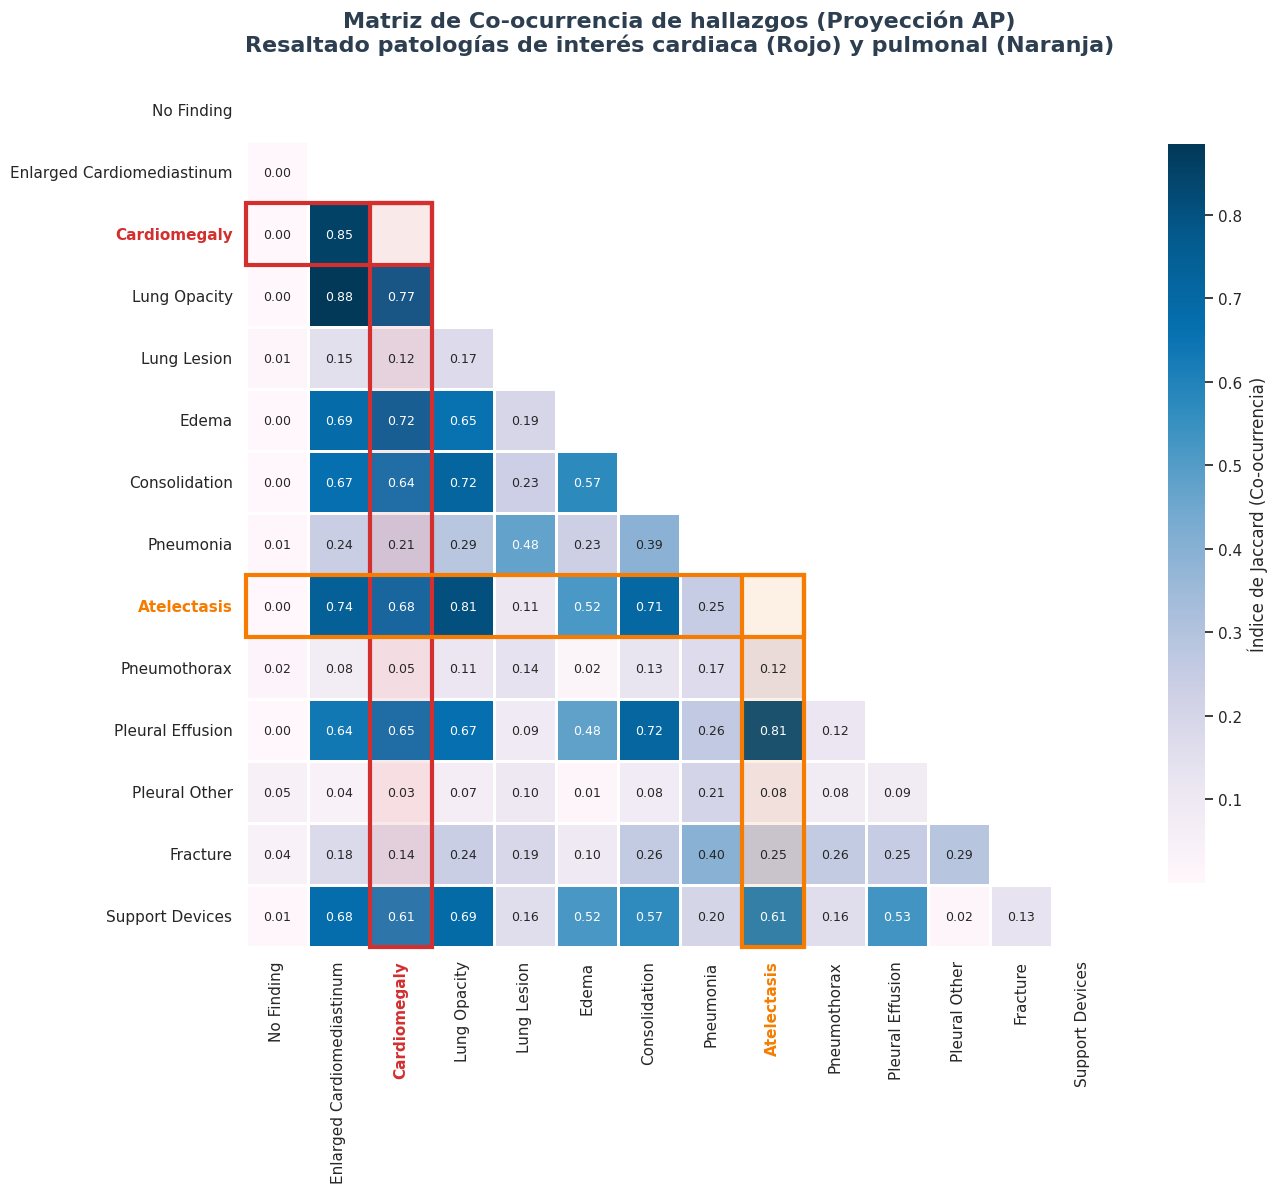

In [75]:
# Analisis de coocurrencias PA
jaccard_matrix = pd.DataFrame(index=labels, columns=labels)

for row_label in labels:
    for col_label in labels:
        if row_label == col_label:
            jaccard_matrix.loc[row_label, col_label] = 1.0
        else:
            # Calculamos Jaccard solo entre estas dos columnas
            y_true = df_2[row_label]
            y_pred = df_2[col_label]
            # average='binary' es clave aquí
            score = jaccard_score(y_true, y_pred, average='binary')
            jaccard_matrix.loc[row_label, col_label] = score

# Convertimos a float para graficar
jaccard_matrix = jaccard_matrix.astype(float)

import matplotlib.patches as patches


MEDICAL_COLORS = {
    'heatmap_bg': 'PuBu',
    'cardio': '#D32F2F',
    'lung':   '#F57C00',
    'text':   '#2C3E50'
}


mask = np.triu(np.ones_like(jaccard_matrix, dtype=bool))

plt.figure(figsize=(14, 12))


ax = sns.heatmap(jaccard_matrix,
                 mask=mask,
                 annot=True,
                 fmt=".2f",
                 cmap=MEDICAL_COLORS['heatmap_bg'],
                 cbar_kws={"shrink": .8, "label": "Índice de Jaccard (Co-ocurrencia)"},
                 linewidths=1,
                 linecolor='white',
                 square=True,
                 annot_kws={"size": 9}
                 )



highlights = [
    {'label': 'Cardiomegaly', 'color': MEDICAL_COLORS['cardio'], 'group': 'Patología Cardíaca'},
    {'label': 'Atelectasis',  'color': MEDICAL_COLORS['lung'],   'group': 'Patología Pulmonar'}
]

for item in highlights:
    target = item['label']
    color = item['color']

    if target in labels:
        idx = labels.index(target)

        # A. EL RECTÁNGULO VERTICAL

        rect_col = patches.Rectangle(
            (idx, idx),
            1, len(labels) - idx,
            linewidth=3,
            edgecolor=color,
            facecolor=color,
            alpha=0.1,             # Transparencia leve de fondo
            clip_on=False
        )
        # Borde fuerte encima del relleno
        rect_col_border = patches.Rectangle(
            (idx, idx),
            1, len(labels) - idx,
            linewidth=3,
            edgecolor=color,
            facecolor='none',
            clip_on=False
        )
        ax.add_patch(rect_col)
        ax.add_patch(rect_col_border)

        # B. EL RECTÁNGULO HORIZONTAL (Fila)
        rect_row = patches.Rectangle(
            (0, idx),
            idx + 1, 1,
            linewidth=3,
            edgecolor=color,
            facecolor='none',
            clip_on=False
        )
        ax.add_patch(rect_row)

        # C. ETIQUETAS COLOREADAS
        # Eje X
        ax.get_xticklabels()[idx].set_color(color)
        ax.get_xticklabels()[idx].set_fontweight('bold')
        ax.get_xticklabels()[idx].set_fontsize(11)

        # Eje Y
        ax.get_yticklabels()[idx].set_color(color)
        ax.get_yticklabels()[idx].set_fontweight('bold')
        ax.get_yticklabels()[idx].set_fontsize(11)

plt.title("Matriz de Co-ocurrencia de hallazgos (Proyección AP)\nResaltado patologías de interés cardiaca (Rojo) y pulmonal (Naranja)",
          fontsize=16, color=MEDICAL_COLORS['text'], pad=20)

plt.show()

# Índice de Carga Patológica
Se crea un indicador compuesto denominado 'Carga Patológica' mediante la suma de hallazgos positivos por paciente. Esto permite categorizar a los pacientes según la severidad global de su cuadro radiológico (Sano, Leve/Moderado, Severo).

In [76]:
# Lista de patologías a analizar
patologias = [
    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
    'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
    'Pleural Effusion', 'Pleural Other', 'Fracture'
]

# 1. Conversión a numérico y llenado de nulos con 0
for col in patologias:
    if col in final_dataset_clean.columns:
        final_dataset_clean[col] = pd.to_numeric(final_dataset_clean[col], errors='coerce').fillna(0)

# 2. Cálculo de la carga patológica (Suma de hallazgos positivos)
final_dataset_clean['Pathology_Burden'] = final_dataset_clean[patologias].sum(axis=1)

# 3. Categorización en niveles de severidad
# Sano: 0 | Leve/Moderado: 1-2 | Severo: >2
final_dataset_clean['Burden_Category'] = pd.cut(
    final_dataset_clean['Pathology_Burden'],
    bins=[-1, 0, 2, 20],
    labels=['Sano', 'Leve/Mod', 'Severo']
)

print("Distribución de Carga Patológica:")
display(final_dataset_clean['Burden_Category'].value_counts(normalize=True).to_frame())

Distribución de Carga Patológica:


,proportion
Burden_Category,
Severo,0.733548
Sano,0.180217
Leve/Mod,0.086234


# Pruebas Estadísticas de Independencia
Se aplican pruebas de Chi-cuadrado para evaluar estadísticamente la asociación entre variables demográficas (edad, etnia, raza) y la presencia de patologías específicas o el nivel de severidad clínica.

In [77]:
# analisis de chi cuadrado grupo de edad vs hallazgos radiologicos ( cardiomegaly, atelectasis)
import scipy.stats as stats
#!pip install statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Tabla de contingencia para Cardiomegaly
contingency_table_cardiomegaly = pd.crosstab(final_dataset_clean['age_group'], final_dataset_clean['Cardiomegaly'])
print("Tabla de Contingencia para Cardiomegaly:")
print(contingency_table_cardiomegaly)
# Prueba de Chi-cuadrado para Cardiomegaly
chi2_cardiomegaly, p_cardiomegaly, dof_cardiomegaly, expected_cardiomegaly = stats.chi2_contingency(contingency_table_cardiomegaly)
print(f"\nResultados de la Prueba de Chi-cuadrado para Cardiomegaly:")
print(f"Chi-cuadrado: {chi2_cardiomegaly}")
print(f"P-valor: {p_cardiomegaly}")
# Tabla de contingencia para Atelectasis
contingency_table_atelectasis = pd.crosstab(final_dataset_clean['age_group'], final_dataset_clean['Atelectasis'])
print("\nTabla de Contingencia para Atelectasis:")
print(contingency_table_atelectasis)
# Prueba de Chi-cuadrado para Atelectasis
chi2_atelectasis, p_atelectasis, dof_atelectasis, expected_atelectasis = stats.chi2_contingency(contingency_table_atelectasis)
print(f"\nResultados de la Prueba de Chi-cuadrado para Atelectasis:")
print(f"Chi-cuadrado: {chi2_atelectasis}")
print(f"P-valor: {p_atelectasis}")
# Interpretación de resultados
alpha = 0.05
if p_cardiomegaly < alpha:
    print("\nSe rechaza la hipótesis nula para Cardiomegaly: Existe una asociación significativa entre el grupo de edad y la presencia de Cardiomegaly.")
else:
    print("\nNo se rechaza la hipótesis nula para Cardiomegaly: No existe una asociación significativa entre el grupo de edad y la presencia de Cardiomegaly.")
if p_atelectasis < alpha:
    print("Se rechaza la hipótesis nula para Atelectasis: Existe una asociación significativa entre el grupo de edad y la presencia de Atelectasis.")
else:
    print("No se rechaza la hipótesis nula para Atelectasis: No existe una asociación significativa entre el grupo de edad y la presencia de Atelectasis.")

Tabla de Contingencia para Cardiomegaly:
Cardiomegaly    0.0    1.0
age_group                 
18–29          7183   4716
30–44         11505  10798
45–59         21855  26972
60–74         22754  35384
75+           15130  31942

Resultados de la Prueba de Chi-cuadrado para Cardiomegaly:
Chi-cuadrado: 4716.710279657724
P-valor: 0.0

Tabla de Contingencia para Atelectasis:
Atelectasis    0.0    1.0
age_group                
18–29         6721   5178
30–44        11310  10993
45–59        20855  27972
60–74        21726  36412
75+          16967  30105

Resultados de la Prueba de Chi-cuadrado para Atelectasis:
Chi-cuadrado: 2894.3639658424668
P-valor: 0.0

Se rechaza la hipótesis nula para Cardiomegaly: Existe una asociación significativa entre el grupo de edad y la presencia de Cardiomegaly.
Se rechaza la hipótesis nula para Atelectasis: Existe una asociación significativa entre el grupo de edad y la presencia de Atelectasis.


In [78]:
# analisis de chi cuadrado etnia vs hallazgos radiologicos ( cardiomegaly, atelectasis)
# Tabla de contingencia para Cardiomegaly
contingency_table_cardiomegaly_ethnicity = pd.crosstab(final_dataset_clean['ethnicity_standardized'], final_dataset_clean['Cardiomegaly'])
print("Tabla de Contingencia para Cardiomegaly por Etnia:")
print(contingency_table_cardiomegaly_ethnicity)
# Prueba de Chi-cuadrado para Cardiomegaly
chi2_cardiomegaly_ethnicity, p_cardiomegaly_ethnicity, dof_cardiomegaly_ethnicity, expected_cardiomegaly_ethnicity = stats.chi2_contingency(contingency_table_cardiomegaly_ethnicity)
print(f"\nResultados de la Prueba de Chi-cuadrado para Cardiomegaly por Etnia:")
print(f"Chi-cuadrado: {chi2_cardiomegaly_ethnicity}")
print(f"P-valor: {p_cardiomegaly_ethnicity}")
# Tabla de contingencia para Atelectasis
contingency_table_atelectasis_ethnicity = pd.crosstab(final_dataset_clean   ['ethnicity_standardized'], final_dataset_clean['Atelectasis'])
print("\nTabla de Contingencia para Atelectasis por Etnia:")
print(contingency_table_atelectasis_ethnicity)
# Prueba de Chi-cuadrado para Atelectasis
chi2_atelectasis_ethnicity, p_atelectasis_ethnicity, dof_atelectasis_ethnicity, expected_atelectasis_ethnicity = stats.chi2_contingency(contingency_table_atelectasis_ethnicity)
print(f"\nResultados de la Prueba de Chi-cuadrado para Atelectasis por Etnia:")
print(f"Chi-cuadrado: {chi2_atelectasis_ethnicity}")
print(f"P-valor: {p_atelectasis_ethnicity}")



# Interpretación de resultados
alpha = 0.05
if p_cardiomegaly_ethnicity < alpha:
    print("\nSe rechaza la hipótesis nula para Cardiomegaly por Etnia: Existe una asociación significativa entre la etnia y la presencia de Cardiomegaly.")
else:
    print("\nNo se rechaza la hipótesis nula para Cardiomegaly por Etnia: No existe una asociación significativa entre la etnia y la presencia de Cardiomegaly.")
if p_atelectasis_ethnicity < alpha:
    print("Se rechaza la hipótesis nula para Atelectasis por Etnia: Existe una asociación significativa entre la etnia y la presencia de Atelectasis.")
else:
    print("No se rechaza la hipótesis nula para Atelectasis por Etnia: No existe una asociación significativa entre la etnia y la presencia de Atelectasis.")

Tabla de Contingencia para Cardiomegaly por Etnia:
Cardiomegaly              0.0    1.0
ethnicity_standardized              
Hispanic / Latino        9909  12143
Non-Hispanic            58254  79878
Unknown / Not Reported  10634  17993

Resultados de la Prueba de Chi-cuadrado para Cardiomegaly por Etnia:
Chi-cuadrado: 351.5664151297086
P-valor: 4.553265171411878e-77

Tabla de Contingencia para Atelectasis por Etnia:
Atelectasis               0.0    1.0
ethnicity_standardized              
Hispanic / Latino       10021  12031
Non-Hispanic            57670  80462
Unknown / Not Reported  10240  18387

Resultados de la Prueba de Chi-cuadrado para Atelectasis por Etnia:
Chi-cuadrado: 528.7335317298225
P-valor: 1.538056842947384e-115

Se rechaza la hipótesis nula para Cardiomegaly por Etnia: Existe una asociación significativa entre la etnia y la presencia de Cardiomegaly.
Se rechaza la hipótesis nula para Atelectasis por Etnia: Existe una asociación significativa entre la etnia y la presenc

In [79]:
## Tabla de contingencia para severidad y raza
contingency_table_severity_race = pd.crosstab(final_dataset_clean['race_standardized'], final_dataset_clean['Burden_Category'])
print("Tabla de Contingencia para Severidad y Raza:")
print(contingency_table_severity_race)
# Prueba de Chi-cuadrado para severidad y raza
chi2_severity_race, p_severity_race, dof_severity_race, expected_severity_race = stats.chi2_contingency(contingency_table_severity_race)
print(f"\nResultados de la Prueba de Chi-cuadrado para Severidad y Raza:")
print(f"Chi-cuadrado: {chi2_severity_race}")
print(f"P-valor: {p_severity_race}")

## Tabla de contingencia para severidad y etnia
contingency_table_severity_ethnicity = pd.crosstab(final_dataset_clean['ethnicity_standardized'], final_dataset_clean['Burden_Category'])
print("Tabla de Contingencia para Severidad y Etnia:")
print(contingency_table_severity_ethnicity)
# Prueba de Chi-cuadrado para severidad y etnia
chi2_severity_ethnicity, p_severity_ethnicity, dof_severity_ethnicity, expected_severity_ethnicity = stats.chi2_contingency(contingency_table_severity_ethnicity)
print(f"\nResultados de la Prueba de Chi-cuadrado para Severidad y Etnia:")
print(f"Chi-cuadrado: {chi2_severity_ethnicity}")
print(f"P-valor: {p_severity_ethnicity}")

# Tabla de contingencia para severidad y sexo
contingency_table_severity_sex = pd.crosstab(final_dataset_clean['Sex'], final_dataset_clean['Burden_Category'])
print("Tabla de Contingencia para Severidad y Sexo:")
print(contingency_table_severity_sex)
# Prueba de Chi-cuadrado para severidad y sexo
chi2_severity_sex, p_severity_sex, dof_severity_sex, expected_severity_sex = stats.chi2_contingency(contingency_table_severity_sex)
print(f"\nResultados de la Prueba de Chi-cuadrado para Severidad y Sexo:")
print(f"Chi-cuadrado: {chi2_severity_sex}")
print(f"P-valor: {p_severity_sex}")

Tabla de Contingencia para Severidad y Raza:
Burden_Category                             Sano  Leve/Mod  Severo
race_standardized                                                 
American Indian or Alaska Native              75        28     356
Asian                                       3587      1794   14268
Black or African American                   2019       860    7172
Native Hawaiian or Other Pacific Islander    550       228    1707
Other                                       5993      2135   18804
Unknown / Not Reported                      3088      1628   17051
White                                      18715      9609   79144

Resultados de la Prueba de Chi-cuadrado para Severidad y Raza:
Chi-cuadrado: 722.5495875550831
P-valor: 6.552291777207946e-147
Tabla de Contingencia para Severidad y Etnia:
Burden_Category          Sano  Leve/Mod  Severo
ethnicity_standardized                         
Hispanic / Latino        5017      1764   15271
Non-Hispanic            24902     

# Modelado Multivariable: Regresión Logística Ordinal
Se implementa un modelo de regresión logística ordinal para estimar el efecto ajustado de múltiples factores (edad, sexo, etnia, soporte vital) sobre la severidad clínica. Se calculan y visualizan los Odds Ratios para interpretar el riesgo relativo de cada variable.

In [82]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel

# 1. Preparación de los datos

burden_mapping = {'Sano': 0, 'Leve/Mod': 1, 'Severo': 2}
final_dataset_clean['Burden_Category_Coded'] = final_dataset_clean['Burden_Category'].map(burden_mapping)
df_model = final_dataset_clean[[
    'age_group', 'Sex', 'ethnicity_standardized',
    'race_standardized', 'AP/PA', 'Support Devices',
    'Burden_Category_Coded'
]].dropna()

# 2. Manejo de Variables Categóricas (Dummy Encoding)

X = pd.get_dummies(
    df_model[['age_group', 'Sex', 'ethnicity_standardized', 'race_standardized', 'AP/PA', 'Support Devices']],
    drop_first=True,
    dtype=int
)

y = df_model['Burden_Category_Coded']

# 3. Ajustar el Modelo Ordinal

mod_prob = OrderedModel(y, X, distr='logit')
res_prob = mod_prob.fit(method='bfgs')

# 4. Obtener el Resumen Estadístico
print(res_prob.summary())

# 5. CALCULAR ODDS RATIOS (OR) e Intervalos de Confianza (95%)

params = res_prob.params
conf = res_prob.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']

# Aplicamos exponencial para convertir a Odds Ratio
odds_ratios = np.exp(conf)

print("\n--- ODDS RATIOS E INTERVALOS DE CONFIANZA (95%) ---")
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.673093
         Iterations: 115
         Function evaluations: 117
         Gradient evaluations: 117
                               OrderedModel Results                              
Dep. Variable:     Burden_Category_Coded   Log-Likelihood:            -1.2670e+05
Model:                      OrderedModel   AIC:                         2.534e+05
Method:               Maximum Likelihood   BIC:                         2.536e+05
Date:                   Sun, 11 Jan 2026                                         
Time:                           03:43:23                                         
No. Observations:                 188239                                         
Df Residuals:                     188222                                         
Df Model:                             15                                         
                                                                  coef    std err      

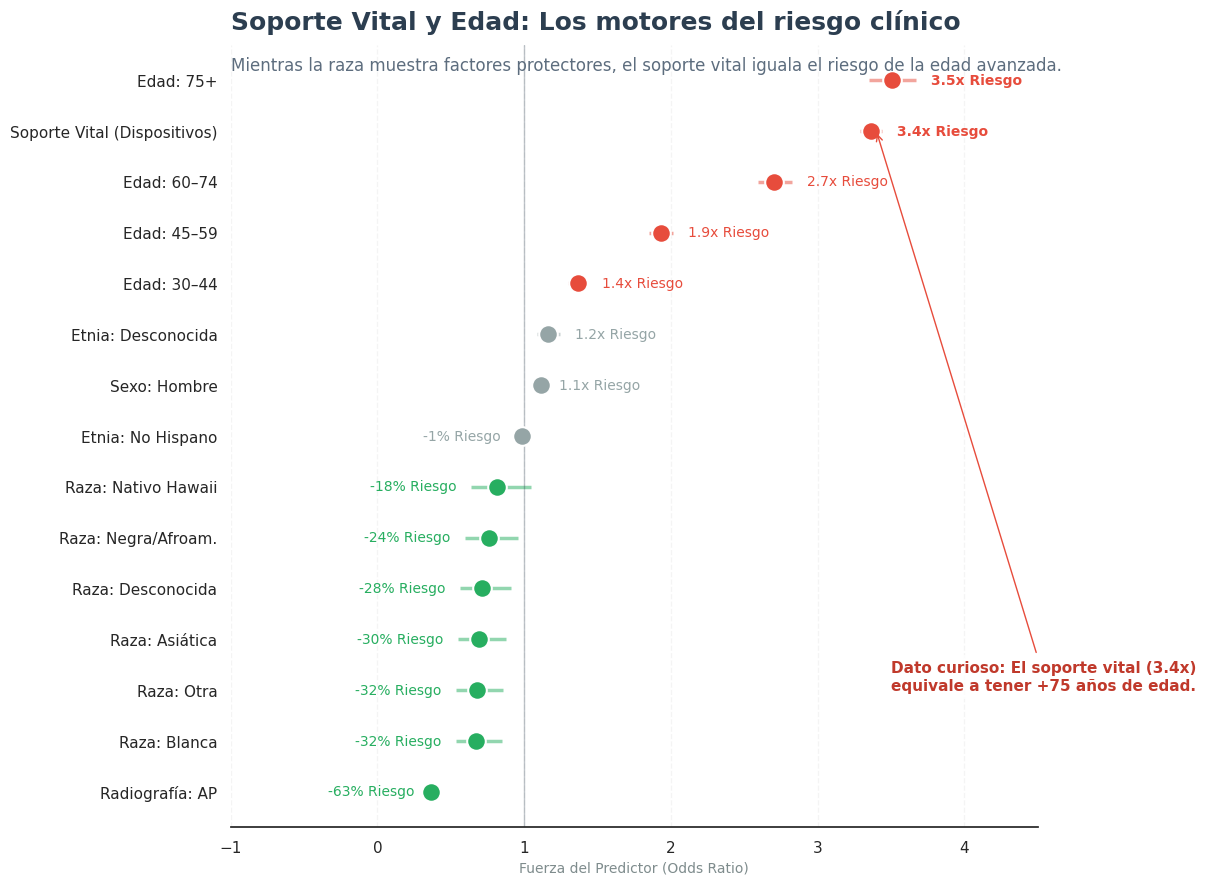

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. DATOS
data = {
    'Factor': [
        'Soporte Vital (Dispositivos)', 'Edad: 75+', 'Edad: 60–74', 'Edad: 45–59', 'Edad: 30–44',
        'Sexo: Hombre', 'Etnia: No Hispano', 'Etnia: Desconocida',
        'Raza: Asiática', 'Raza: Negra/Afroam.', 'Raza: Nativo Hawaii', 'Raza: Otra', 'Raza: Desconocida', 'Raza: Blanca',
        'Radiografía: AP'
    ],
    'OR': [3.363, 3.507, 2.706, 1.932, 1.365, 1.115, 0.986, 1.165, 0.695, 0.759, 0.816, 0.677, 0.716, 0.674, 0.365],
    'CI_Lower': [3.287, 3.352, 2.592, 1.851, 1.302, 1.091, 0.943, 1.089, 0.551, 0.600, 0.637, 0.537, 0.565, 0.535, 0.355],
    'CI_Upper': [3.440, 3.670, 2.826, 2.017, 1.431, 1.140, 1.032, 1.246, 0.877, 0.959, 1.045, 0.853, 0.909, 0.848, 0.375]
}

df = pd.DataFrame(data)
df['Significativo'] = ~((df['CI_Lower'] <= 1) & (df['CI_Upper'] >= 1))

# Ordenar por OR para que la historia fluya de menor a mayor riesgo
df = df.sort_values(by='OR', ascending=True).reset_index(drop=True)

# 2. CONFIGURACIÓN VISUAL
plt.figure(figsize=(12, 9))
ax = plt.gca()

# Colores narrativos
color_critico = '#E74C3C'  # Rojo fuerte para Soporte/Edad
color_protector = '#27AE60' # Verde para Razas/Reducción
color_neutro = '#95A5A6'    # Gris

# 3. DIBUJAR LÍNEAS E INTERVALOS
for i, row in df.iterrows():
    # Definir color según el impacto
    current_color = color_critico if row['OR'] > 1.2 else (color_protector if row['OR'] < 0.9 else color_neutro)

    # Línea de intervalo (CI)
    plt.hlines(y=i, xmin=row['CI_Lower'], xmax=row['CI_Upper'], color=current_color, alpha=0.5, linewidth=2.5)

    # Punto central (OR)
    plt.scatter(row['OR'], i, color=current_color, s=180, zorder=3, edgecolor='white', linewidth=1.5)

    # ETIQUETAS DE TEXTO (Ajustadas para evitar overlap)
    if row['OR'] >= 1:
        text_label = f"{row['OR']:.1f}x Riesgo"
        ax.text(row['CI_Upper'] + 0.1, i, text_label, va='center', ha='left',
                fontsize=10, weight='bold' if row['OR'] > 3 else 'normal', color=current_color)
    else:
        reduction = int((1 - row['OR']) * 100)
        text_label = f"-{reduction}% Riesgo"
        ax.text(row['CI_Lower'] - 0.1, i, text_label, va='center', ha='right',
                fontsize=10, color=current_color)

# 4. ELEMENTOS DE STORYTELLING
plt.axvline(x=1, color='#2C3E50', linestyle='-', linewidth=1, alpha=0.3) # Línea base

# Títulos y subtítulos
plt.text(-1, len(df), 'Soporte Vital y Edad: Los motores del riesgo clínico', fontsize=18, weight='bold', color='#2C3E50')
plt.text(-1, len(df)-0.8, 'Mientras la raza muestra factores protectores, el soporte vital iguala el riesgo de la edad avanzada.',
         fontsize=12, color='#5D6D7E')

# Anotación del "Dato Curioso"
plt.annotate('Dato curioso: El soporte vital (3.4x)\nequivale a tener +75 años de edad.',
             xy=(3.4, df[df['Factor'] == 'Soporte Vital (Dispositivos)'].index[0]),
             xytext=(3.5, 2), arrowprops=dict(arrowstyle='->', color='#E74C3C'),
             fontsize=11, color='#C0392B', weight='bold', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# 5. LIMPIEZA FINAL
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df['Factor'], fontsize=11)
ax.set_xlabel("Fuerza del Predictor (Odds Ratio)", fontsize=10, color='#7F8C8D')
ax.set_xlim(-1, 4.5) # Espacio extra a la izquierda para las etiquetas de %

# Eliminar espinas
sns.despine(left=True, bottom=False)
plt.grid(axis='x', linestyle='--', alpha=0.2)
plt.tight_layout()

plt.show()

In [84]:
print(odds_ratios)

                                                        2.5%     97.5%  \
Support Devices                                     3.287237  3.440540   
age_group_30–44                                     1.302640  1.431856   
age_group_45–59                                     1.851212  2.017857   
age_group_60–74                                     2.592087  2.826097   
age_group_75+                                       3.352259  3.670110   
Sex_Male                                            1.091052  1.140179   
ethnicity_standardized_Non-Hispanic                 0.943189  1.032791   
ethnicity_standardized_Unknown / Not Reported       1.089547  1.246533   
race_standardized_Asian                             0.551684  0.877616   
race_standardized_Black or African American         0.600654  0.959413   
race_standardized_Native Hawaiian or Other Paci...  0.637812  1.045100   
race_standardized_Other                             0.537344  0.853931   
race_standardized_Unknown / Not Report

# Visualización de Prevalencias Específicas
Se presentan gráficos de tendencias para patologías clave (Atelectasia y Cardiomegalia), mostrando cómo varía su prevalencia a través de los grupos de edad, diferenciando por sexo para detectar patrones biológicos.

## Prevalencia de atelectasis por edad y sexo

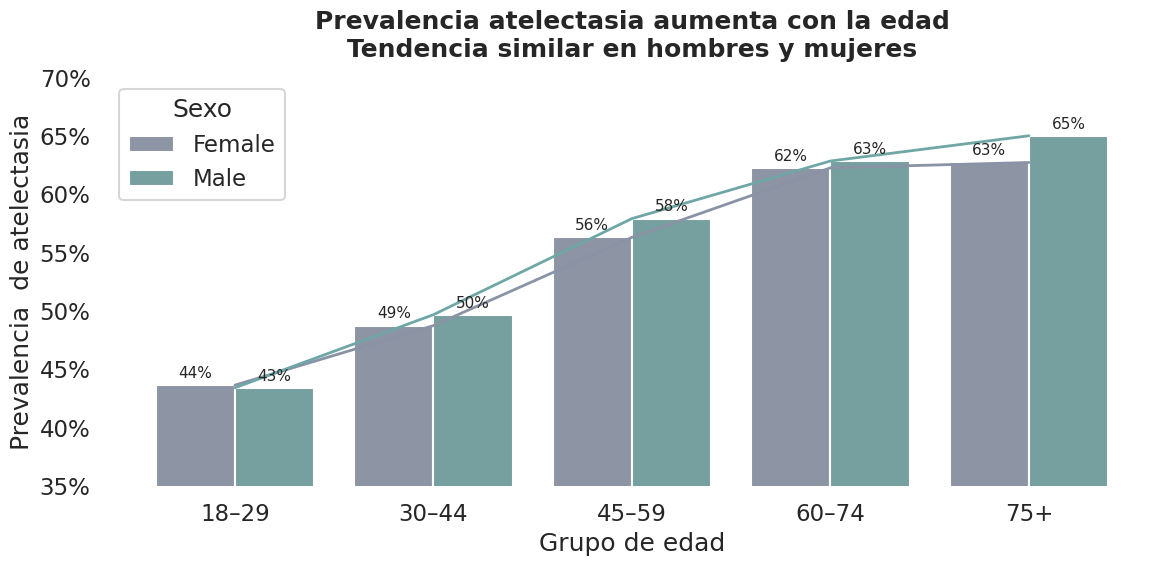

In [85]:
summary = (
    final_dataset_clean
    .groupby(['age_group', 'Sex'])
    .agg(
        p=('Atelectasis', 'mean'),
        n=('Atelectasis', 'count')
    )
    .reset_index()
)


sns.set_theme(style="white", context="talk")


palette = {
    'Female': '#8A93A6',   # gris azulado
    'Male': '#6FA6A6'      # verde clínico
}

plt.figure(figsize=(12, 6))

# Barras
ax = sns.barplot(
    data=summary,
    x='age_group',
    y='p',
    hue='Sex',
    palette=palette,
    dodge=True
)

# Línea de tendencia (
sns.lineplot(
    data=summary,
    x='age_group',
    y='p',
    hue='Sex',
    palette=palette,
    markers=True,
    linewidth=2,
    legend=False,
    ax=ax
)


for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{v.get_height()*100:.0f}%" for v in container],
        padding=3,
        fontsize=11
    )

# Etiquetas
ax.set_title(
    'Prevalencia atelectasia aumenta con la edad\nTendencia similar en hombres y mujeres',
    fontsize=18,
    weight='bold',
    pad=15
)

ax.set_xlabel('Grupo de edad')
ax.set_ylabel('Prevalencia  de atelectasia')
ax.set_ylim(0.35, 0.7)
ax.yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')

ax.legend(title='Sexo', loc='upper left')
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

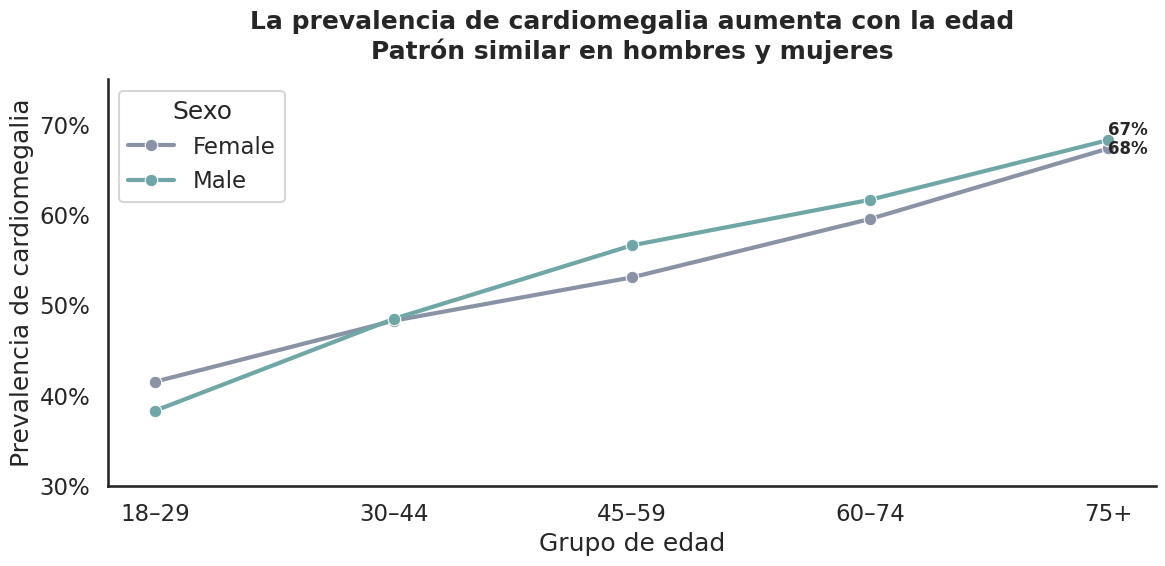

In [86]:
summary = (
    final_dataset_clean
    .groupby(['age_group', 'Sex'])
    .agg(
        prevalence=('Cardiomegaly', 'mean'),
        n=('Cardiomegaly', 'count')
    )
    .reset_index()
)
age_order = ['18–29', '30–44', '45–59', '60–74', '75+']
summary['age_group'] = pd.Categorical(
    summary['age_group'],
    categories=age_order,
    ordered=True
)

sns.set_theme(style="white", context="talk")

palette = {
    'Female': '#8A93A6',
    'Male': '#6FA6A6'
}

plt.figure(figsize=(12, 6))

ax = sns.lineplot(
    data=summary,
    x='age_group',
    y='prevalence',
    hue='Sex',
    palette=palette,
    linewidth=3,
    marker='o'
)

# Etiquetar solo último punto
offset = {'Female': 0.015, 'Male': -0.015}
for sex in summary['Sex'].unique():
    last = (
        summary[summary['Sex'] == sex]
        .sort_values('age_group')
        .iloc[-1]
    )
    ax.text(
        last['age_group'],
        last['prevalence'] + offset[sex],
        f"{last['prevalence']*100:.0f}%",
        fontsize=12,
        weight='bold'
    )

ax.set_title(
    'La prevalencia de cardiomegalia aumenta con la edad\n'
    'Patrón similar en hombres y mujeres',
    fontsize=18,
    weight='bold',
    pad=15
)

ax.set_xlabel('Grupo de edad')
ax.set_ylabel('Prevalencia de cardiomegalia')
ax.yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')
ax.set_ylim(0.3, 0.75)

ax.legend(title='Sexo')
sns.despine()

plt.tight_layout()
plt.show()

# Análisis de Carga Patológica Promedio
Se examina la evolución de la carga patológica media (cantidad promedio de hallazgos) con la edad y se evalúa cuantitativamente el impacto que tiene el uso de dispositivos médicos de soporte vital en la complejidad del paciente.

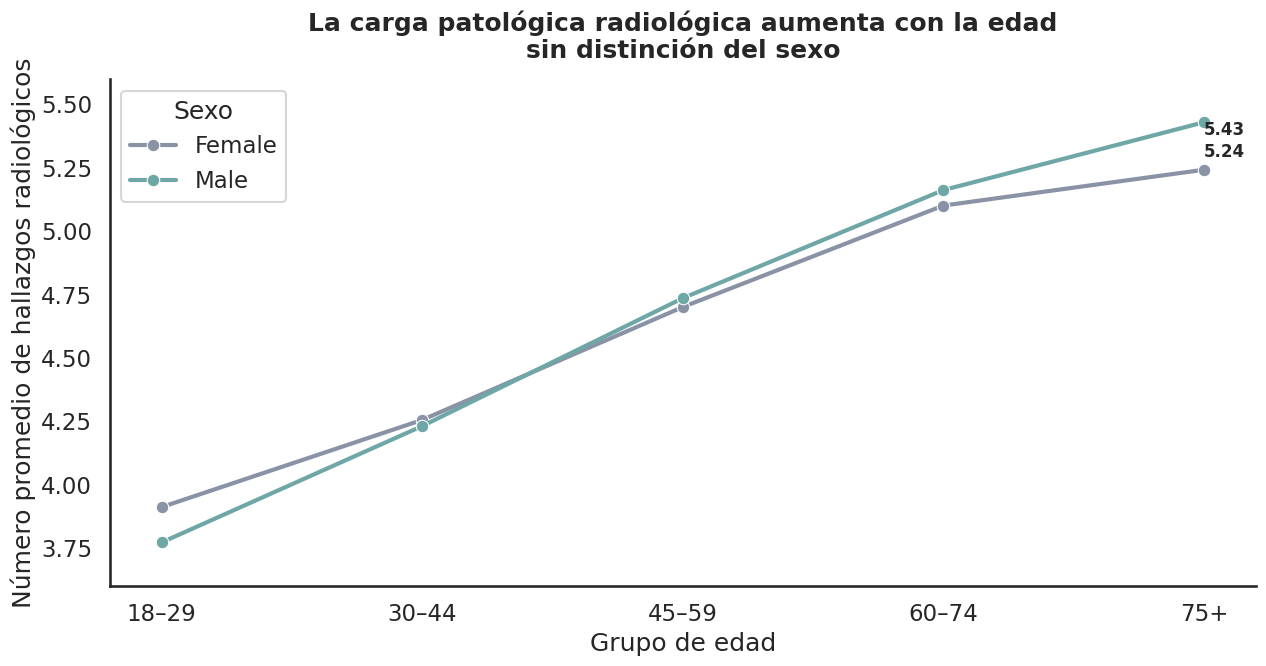

In [87]:
summary = (
    final_dataset_clean
    .groupby(['age_group', 'Sex'])
    .agg(
        mean_burden=('Pathology_Burden', 'mean'),
        n=('Pathology_Burden', 'count')
    )
    .reset_index()
)

# Orden de edad
age_order = ['18–29', '30–44', '45–59', '60–74', '75+']
summary['age_group'] = pd.Categorical(
    summary['age_group'],
    categories=age_order,
    ordered=True
)


sns.set_theme(style="white", context="talk")

palette = {
    'Female': '#8A93A6',
    'Male': '#6FA6A6'
}

plt.figure(figsize=(13, 7))

ax = sns.lineplot(
    data=summary,
    x='age_group',
    y='mean_burden',
    hue='Sex',
    palette=palette,
    linewidth=3,
    marker='o'
)



offset = {'Female': 0.05, 'Male': -0.05}

for sex in summary['Sex'].unique():
    last = (
        summary[summary['Sex'] == sex]
        .sort_values('age_group')
        .iloc[-1]
    )
    ax.text(
        last['age_group'],
        last['mean_burden'] + offset[sex],
        f"{last['mean_burden']:.2f}",
        fontsize=12,
        weight='bold'
    )


ax.set_title(
    'La carga patológica radiológica aumenta con la edad\n'
    'sin distinción del sexo',
    fontsize=18,
    weight='bold',
    pad=15
)

ax.set_xlabel('Grupo de edad')
ax.set_ylabel('Número promedio de hallazgos radiológicos')
ax.set_ylim(3.6, 5.6)

ax.legend(title='Sexo')
sns.despine()

plt.tight_layout()
plt.show()

# Kruskal- wallis
Método estadístico no paramétrico para comparar tres o más grupos independientes, evaluando si provienen de la misma población o si sus medianas son diferentes
H0 (Nula): Todas las muestras provienen de la misma población (medianas iguales).
H1 (Alternativa): Al menos una muestra proviene de una población con una mediana diferente.

In [88]:
from scipy.stats import kruskal

groups = [
    final_dataset_clean.loc[
        final_dataset_clean['age_group'] == g,
        'Pathology_Burden'
    ].dropna()
    for g in age_order
]

stat, p_value = kruskal(*groups)

print(f"Kruskal–Wallis H = {stat:.2f}, p = {p_value:.4f}")

Kruskal–Wallis H = 3485.22, p = 0.0000


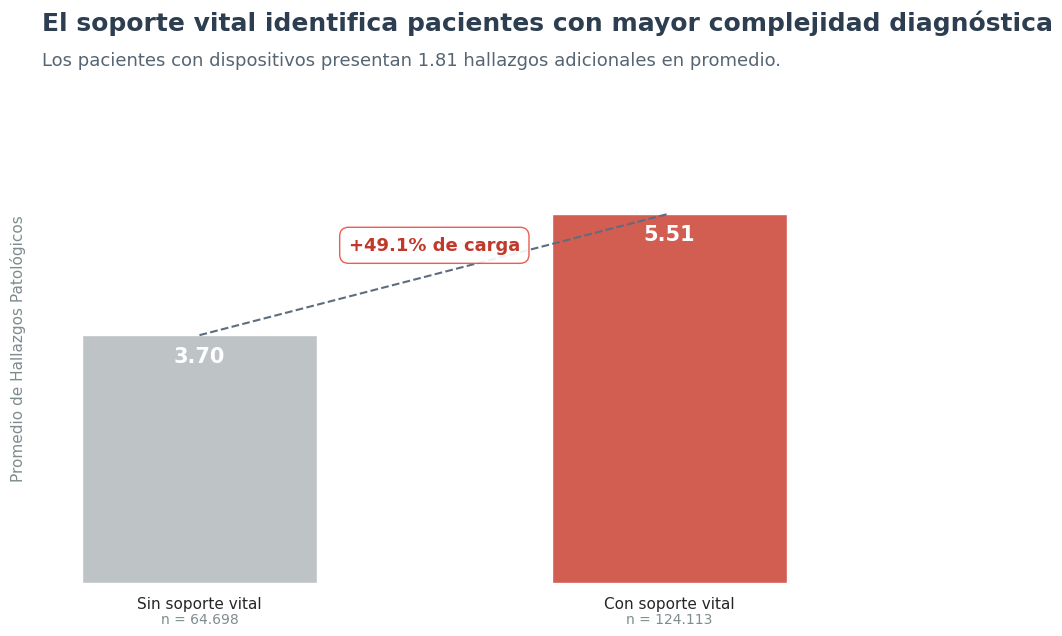

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparación de datos (Basado en tu dataset)
final_dataset_clean['support_device'] = np.where(
    final_dataset_clean['Support Devices'] == 1,
    'Con soporte vital',
    'Sin soporte vital'
)

summary = (
    final_dataset_clean
    .groupby('support_device')
    .agg(
        mean_burden=('Pathology_Burden', 'mean'),
        n=('Pathology_Burden', 'count')
    )
    .sort_values('mean_burden')
    .reset_index()
)

# Cálculos
val_sin = summary.loc[summary['support_device'] == 'Sin soporte vital', 'mean_burden'].values[0]
val_con = summary.loc[summary['support_device'] == 'Con soporte vital', 'mean_burden'].values[0]
pct_diff = ((val_con / val_sin) - 1) * 100

# 2. Configuración estética mejorada
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(10, 7))

palette = {'Sin soporte vital': '#BDC3C7', 'Con soporte vital': '#E74C3C'}

sns.barplot(
    data=summary,
    x='support_device',
    y='mean_burden',
    palette=palette,
    width=0.5,
    ax=ax
)

# 3. STORYTELLING: Línea de conexión y porcentaje
plt.plot([0, 1], [val_sin, val_con], color="#5D6D7E", linestyle="--", linewidth=1.5, zorder=3)

# Ajuste de la caja de porcentaje para que no choque
plt.text(
    0.5, (val_sin + val_con) / 2 + 0.3,
    f"+{pct_diff:.1f}% de carga",
    ha='center', va='bottom', fontsize=13, weight='bold', color='#C0392B',
    bbox=dict(facecolor='white', edgecolor='#E74C3C', boxstyle='round,pad=0.5', alpha=0.9)
)

# 4. Etiquetas de datos dentro de las barras
for i, row in summary.iterrows():
    ax.text(
        i, row['mean_burden'] - 0.4,
        f"{row['mean_burden']:.2f}",
        ha='center', color='white', weight='bold', fontsize=15
    )
    # n-values: los bajamos un poco más para que no toquen el nombre del eje
    ax.text(
        i, -0.6,
        f"n = {row['n']:,}".replace(',', '.'),
        ha='center', fontsize=10, color='#7F8C8D', weight='normal'
    )

# 5. Títulos con espaciado controlado (Fix para letras encimadas)
# Usamos fig.text para tener control total sobre la posición
fig.text(
    0.12, 0.94, 'El soporte vital identifica pacientes con mayor complejidad diagnóstica',
    fontsize=18, weight='bold', color='#2C3E50'
)
fig.text(
    0.12, 0.89, f'Los pacientes con dispositivos presentan {val_con - val_sin:.2f} hallazgos adicionales en promedio.',
    fontsize=13, color='#566573'
)

# Limpieza de ejes
ax.set_xlabel('')
ax.set_ylabel('Promedio de Hallazgos Patológicos', fontsize=11, color='#7F8C8D', labelpad=15)
ax.set_ylim(0, 7) # Damos aire arriba
sns.despine(left=True, bottom=True)
ax.get_yaxis().set_ticks([]) # Ocultar escala Y para limpieza

# Ajuste manual del margen superior para que el título no se corte
plt.subplots_adjust(top=0.82, bottom=0.15)

plt.show()

# Análisis de Severidad por Factores Demográficos y Técnicos
Se presentan visualizaciones comparativas (barras apiladas y simples) para examinar cómo se distribuye la severidad clínica (Sano/Leve/Severo) según la raza, etnia y el tipo de proyección radiológica utilizada.

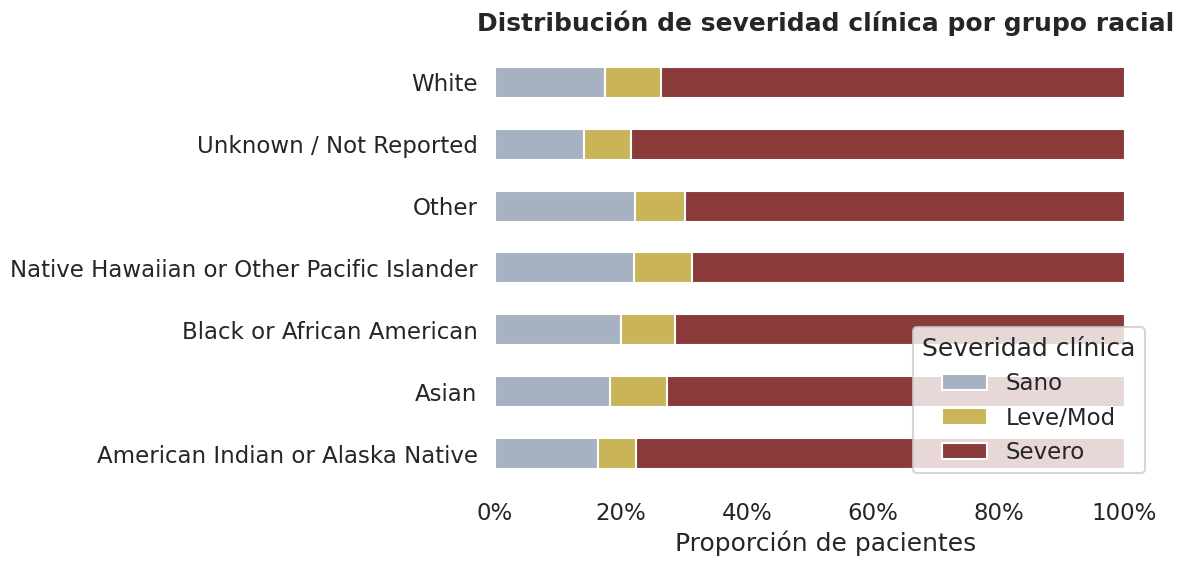

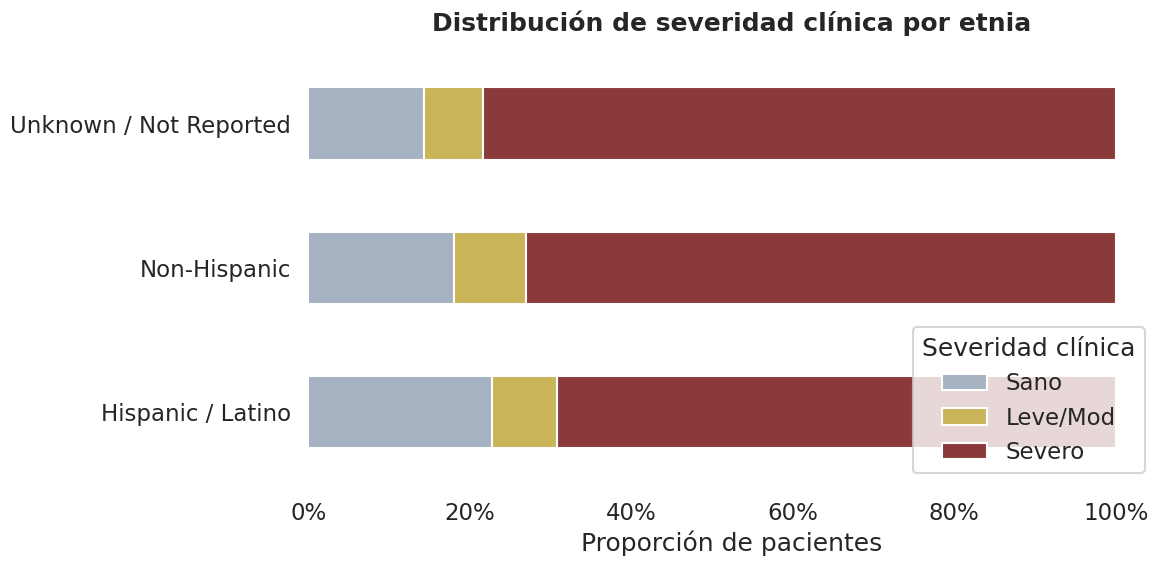

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", context="talk")

severity_colors = {
    'Sano': '#A6B1C2',       # gris azulado
    'Leve/Mod': '#C9B458',   # ámbar clínico
    'Severo': '#8B3A3A'      # rojo oscuro sobrio
}

def stacked_severity_plot(data, group_var, title, xlabel):
    severity = (
        data
        .groupby([group_var, 'Burden_Category'])
        .size()
        .unstack(fill_value=0)[severity_colors.keys()]
    )

    severity_pct = severity.div(severity.sum(axis=1), axis=0)

    ax = severity_pct.plot(
        kind='barh',
        stacked=True,
        figsize=(12, 6),
        color=severity_colors.values()
    )

    ax.set_title(title, fontsize=18, weight='bold', pad=15)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('')
    ax.xaxis.set_major_formatter(lambda x, _: f'{x:.0%}')
    ax.legend(
        title='Severidad clínica',
        loc='lower right'
    )

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

stacked_severity_plot(
    final_dataset_clean,
    group_var='race_standardized',
    title='Distribución de severidad clínica por grupo racial',
    xlabel='Proporción de pacientes'
)
stacked_severity_plot(
    final_dataset_clean,
    group_var='ethnicity_standardized',
    title='Distribución de severidad clínica por etnia',
    xlabel='Proporción de pacientes'
)

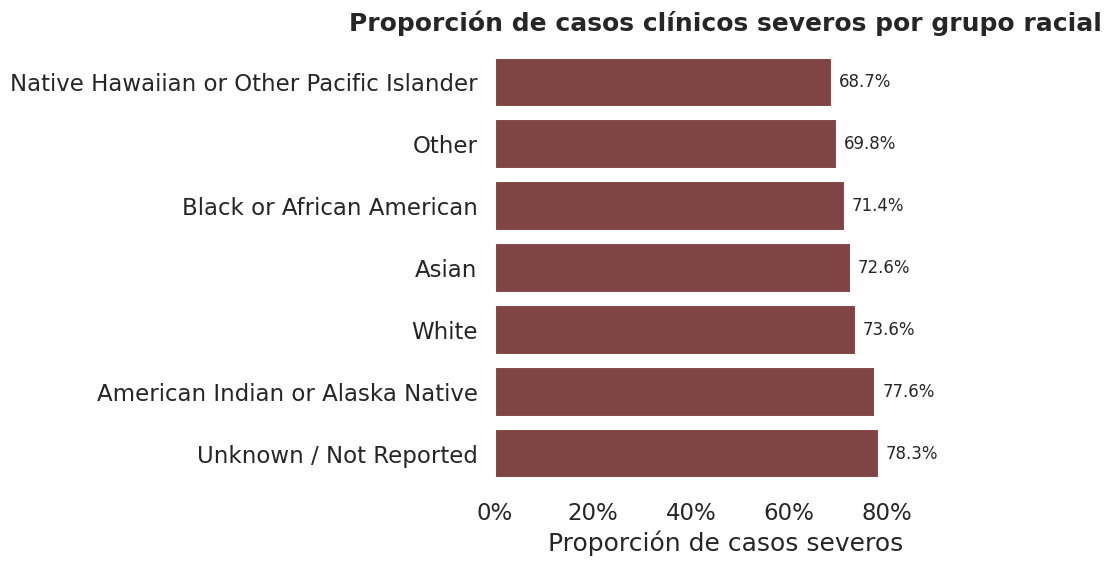

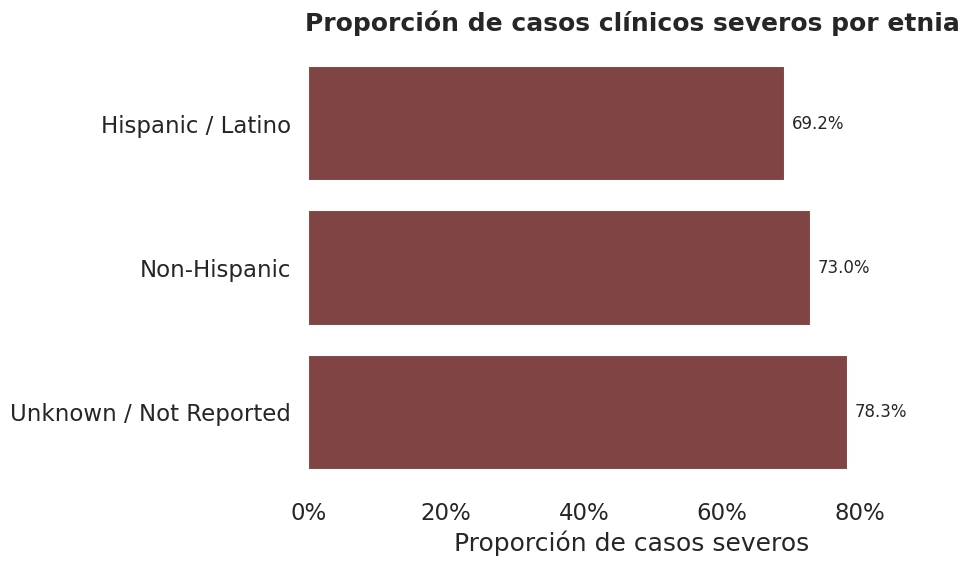

In [91]:
sns.set_theme(style="white", context="talk")

severity_race_severe = (
    final_dataset_clean
    .assign(severe=lambda x: x['Burden_Category'] == 'Severo')
    .groupby('race_standardized')['severe']
    .mean()
    .reset_index()
)
severity_ethnicity_severe = (
    final_dataset_clean
    .assign(severe=lambda x: x['Burden_Category'] == 'Severo')
    .groupby('ethnicity_standardized')['severe']
    .mean()
    .reset_index()
)
def severe_barplot(data, group_var, title):
    plt.figure(figsize=(10, 6))

    ax = sns.barplot(
        data=data.sort_values('severe'),
        x='severe',
        y=group_var,
        color='#8B3A3A'  # rojo oscuro clínico (no alarmista)
    )

    # Etiquetas de porcentaje
    for container in ax.containers:
        ax.bar_label(
            container,
            labels=[f"{v.get_width()*100:.1f}%" for v in container],
            padding=5,
            fontsize=12
        )

    ax.set_title(title, fontsize=18, weight='bold', pad=15)
    ax.set_xlabel('Proporción de casos severos')
    ax.set_ylabel('')
    ax.xaxis.set_major_formatter(lambda x, _: f'{x:.0%}')
    ax.set_xlim(0, data['severe'].max() * 1.2)

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

severe_barplot(
    severity_race_severe,
    group_var='race_standardized',
    title='Proporción de casos clínicos severos por grupo racial'
)
severe_barplot(
    severity_ethnicity_severe,
    group_var='ethnicity_standardized',
    title='Proporción de casos clínicos severos por etnia'
)

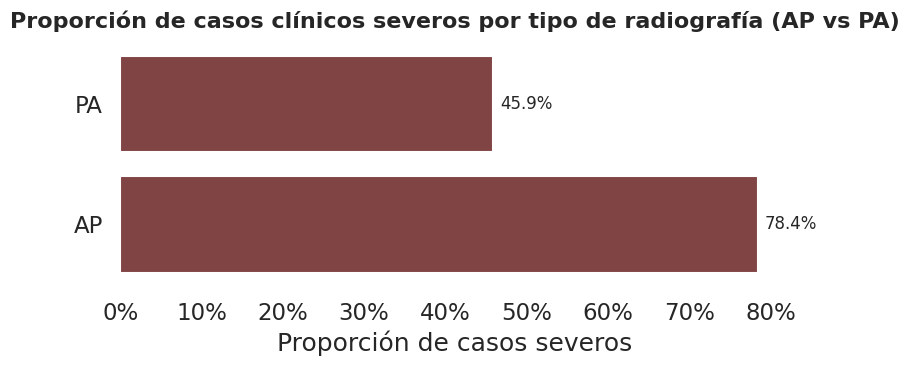

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", context="talk")

severity_view_severe = (
    final_dataset_clean
    .assign(severe=lambda x: x['Burden_Category'] == 'Severo')
    .groupby('AP/PA')['severe']
    .mean()
    .reset_index()
)

def severe_view_barplot(data, title):
    plt.figure(figsize=(8, 4))

    ax = sns.barplot(
        data=data.sort_values('severe'),
        x='severe',
        y='AP/PA',
        color='#8B3A3A'  # rojo oscuro clínico, sobrio
    )

    # Etiquetas de porcentaje
    for container in ax.containers:
        ax.bar_label(
            container,
            labels=[f"{v.get_width()*100:.1f}%" for v in container],
            padding=5,
            fontsize=12
        )

    ax.set_title(title, fontsize=16, weight='bold', pad=12)
    ax.set_xlabel('Proporción de casos severos')
    ax.set_ylabel('')
    ax.xaxis.set_major_formatter(lambda x, _: f'{x:.0%}')

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

severe_view_barplot(
    severity_view_severe,
    title='Proporción de casos clínicos severos por tipo de radiografía (AP vs PA)'
)

# Análisis de Estudios Normales y Conclusiones Visuales
Se finaliza el análisis con una visualización avanzada que compara la proporción de estudios radiológicos reportados como "normales" (sin hallazgos) entre los distintos grupos raciales, lo que permite inferir disparidades en la carga de enfermedad base al momento de realizar el estudio.

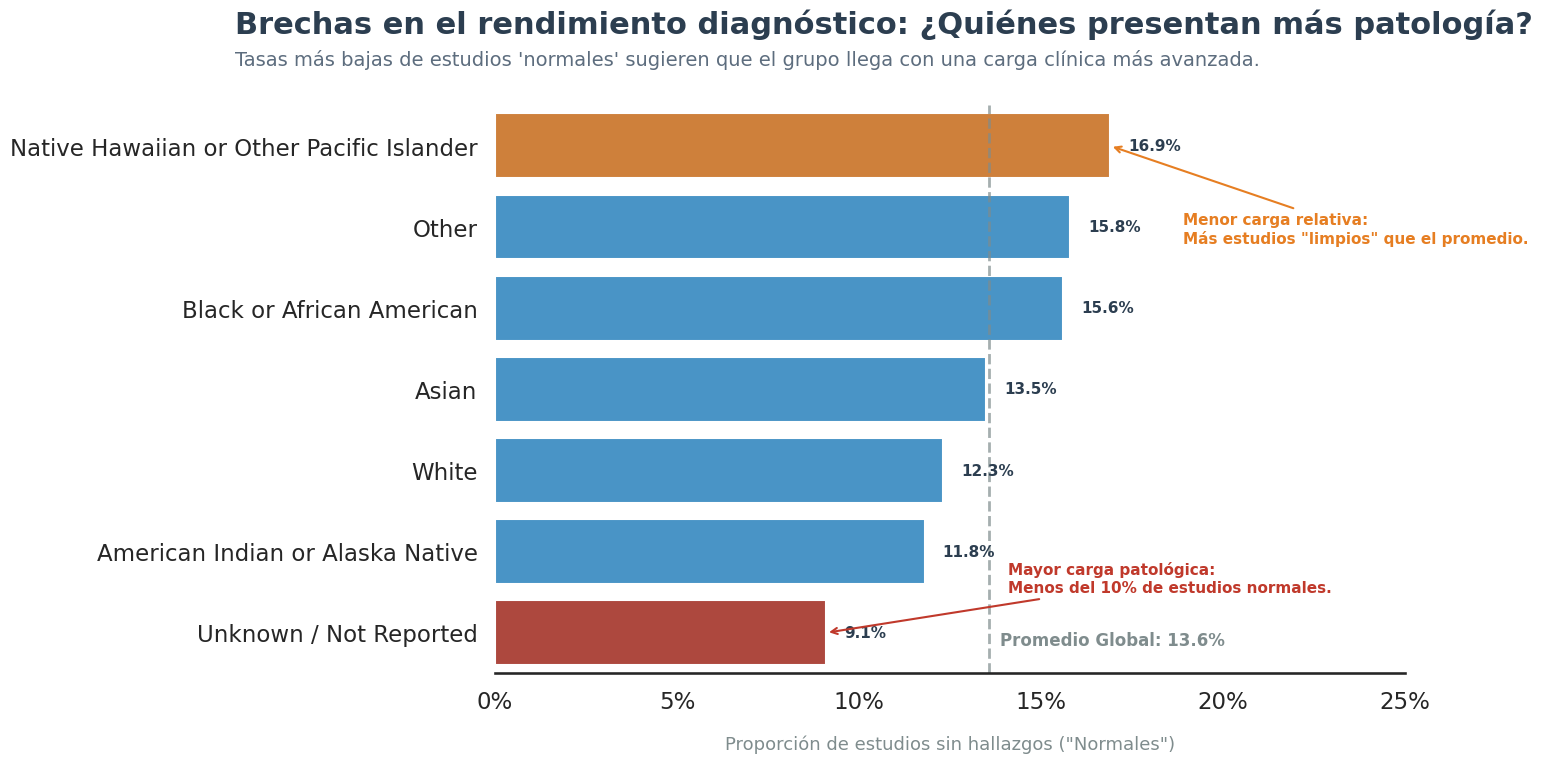

In [93]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


# --- SIMULACIÓN DE DATOS PARA QUE EL CÓDIGO SEA EJECUTABLE ---
# (Reemplaza esto con tus datos reales)
data = {
    'race_standardized': ['Native Hawaiian or Other Pacific Islander', 'Other', 'Black or African American',
                          'Asian', 'White', 'American Indian or Alaska Native', 'Unknown / Not Reported'],
    'no_finding_rate': [0.169, 0.158, 0.156, 0.135, 0.123, 0.118, 0.091],
    'n': [100, 200, 500, 300, 1000, 150, 250] # Datos ficticios para n
}
no_finding_summary = pd.DataFrame(data)
# ------------------------------------------------------------


# 1. Preparación y cálculos
no_finding_summary = no_finding_summary.sort_values('no_finding_rate', ascending=False).reset_index(drop=True)
avg_rate = no_finding_summary['no_finding_rate'].mean()

# Crear colores condicionales
def set_color(rate):
    if rate == no_finding_summary['no_finding_rate'].max(): return '#E67E22' # Naranja (Más "Normales")
    if rate == no_finding_summary['no_finding_rate'].min(): return '#C0392B' # Rojo (Más Patología)
    return '#3498DB' # Azul estándar

no_finding_summary['color'] = no_finding_summary['no_finding_rate'].apply(set_color)

# 2. Configuración visual (Usamos fig y ax para mejor control)
sns.set_theme(style="white", context="talk")
fig, ax = plt.subplots(figsize=(13, 8)) # Aumenté un poco el ancho

sns.barplot(
    data=no_finding_summary,
    x='no_finding_rate',
    y='race_standardized',
    palette=list(no_finding_summary['color']),
    ax=ax
)

# 3. Línea de Promedio Global y su Etiqueta
ax.axvline(avg_rate, color='#7F8C8D', linestyle='--', linewidth=2, alpha=0.7)
# CORRECCIÓN: Moví la etiqueta abajo, donde hay espacio blanco
ax.text(avg_rate + 0.003, len(no_finding_summary)-0.8, f'Promedio Global: {avg_rate:.1%}',
        color='#7F8C8D', weight='bold', va='bottom', fontsize=12)


# 4. Etiquetas de datos al final de las barras
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 0.005, p.get_y() + p.get_height()/2,
            f'{width:.1%}', va='center', fontsize=11, weight='bold', color='#2C3E50')

# 5. Títulos narrativos (CORRECCIÓN: Usar fig.text para evitar solapamiento)
fig.suptitle("Brechas en el rendimiento diagnóstico: ¿Quiénes presentan más patología?",
             fontsize=22, weight='bold', color='#2C3E50', x=0.05, ha='left', y=0.98)
fig.text(0.05, 0.91, "Tasas más bajas de estudios 'normales' sugieren que el grupo llega con una carga clínica más avanzada.",
         fontsize=14, color='#5D6D7E', ha='left')

# 6. Anotaciones estratégicas (CORRECCIÓN: Ajuste de coordenadas para buscar espacio blanco)

# Nota sobre el valor MÍNIMO (Rojo - Mayor Patología)
# Buscamos el índice de la tasa más baja
idx_min = no_finding_summary[no_finding_summary['no_finding_rate'] == no_finding_summary['no_finding_rate'].min()].index[0]
val_min = no_finding_summary['no_finding_rate'].min()

ax.annotate('Mayor carga patológica:\nMenos del 10% de estudios normales.',
             xy=(val_min, idx_min), xycoords='data',
             xytext=(val_min + 0.05, idx_min - 0.5), textcoords='data', # Movemos el texto a la derecha y arriba
             arrowprops=dict(arrowstyle='->', color='#C0392B', lw=1.5),
             color='#C0392B', fontsize=11, weight='bold', ha='left')

# Nota sobre el valor MÁXIMO (Naranja - Menor Carga Relativa)
idx_max = no_finding_summary[no_finding_summary['no_finding_rate'] == no_finding_summary['no_finding_rate'].max()].index[0]
val_max = no_finding_summary['no_finding_rate'].max()

ax.annotate('Menor carga relativa:\nMás estudios "limpios" que el promedio.',
             xy=(val_max, idx_max), xycoords='data',
             xytext=(val_max + 0.02, idx_max + 1.2), textcoords='data', # Movemos el texto abajo y derecha
             arrowprops=dict(arrowstyle='->', color='#E67E22', lw=1.5),
             color='#E67E22', fontsize=11, weight='bold', ha='left')


# Limpieza final
ax.set_xlabel('Proporción de estudios sin hallazgos ("Normales")', fontsize=13, color='#7F8C8D', labelpad=15)
ax.set_ylabel('')
ax.set_xlim(0, 0.25) # Damos más aire a la derecha para las anotaciones
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0)) # Formato % limpio

sns.despine(left=True, bottom=False)

# AJUSTE CRÍTICO DE MÁRGENES
plt.subplots_adjust(top=0.86, bottom=0.15, left=0.25, right=0.95)

plt.show()